In [1]:
#!pip install missingno

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import missingno as msno
from scipy.stats import chi2_contingency
from tqdm import tqdm
import scipy.stats as st
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, log_loss
from itertools import product
from collections import Counter
from sklearn.base import clone
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.utils import check_X_y, check_array
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import shap

## Importing Mental Health and GDP Datasets

In [3]:
# Assuming mentalhealth.csv and gdp.csv are in the current working directory
try:
    mental_health_df = pd.read_csv('Data/mentalhealth.csv')
    gdp_df = pd.read_csv('Data/gdp.csv')
    print("Files loaded successfully.")
    print("Mental Health DataFrame:")
    print(mental_health_df)
    print("\nGDP DataFrame:")
    print(gdp_df.head())  # Display the first few rows
except FileNotFoundError:
    print("Error: One or both of the files were not found.  Please ensure they are in the correct location.")
except Exception as e:
    print(f"An error occurred: {e}")


Files loaded successfully.
Mental Health DataFrame:
      sitecode                     sitename  sitetype  sitetypenum  year  \
0           AB         Albuquerque, NM (AB)  District            1  2023   
1           AB         Albuquerque, NM (AB)  District            1  2023   
2           AB         Albuquerque, NM (AB)  District            1  2023   
3           AB         Albuquerque, NM (AB)  District            1  2023   
4           AB         Albuquerque, NM (AB)  District            1  2023   
...        ...                          ...       ...          ...   ...   
22123       SP  Spartanburg County, SC (SP)  District            1  2023   
22124       SP  Spartanburg County, SC (SP)  District            1  2023   
22125       SP  Spartanburg County, SC (SP)  District            1  2023   
22126       SP  Spartanburg County, SC (SP)  District            1  2023   
22127       SP  Spartanburg County, SC (SP)  District            1  2023   

       survyear  weight  stratum  P

## Initial Data Cleaning

In [4]:
#Identifying Uninformative Columns
for col in mental_health_df.columns:
  if mental_health_df[col].nunique() <=1:
    print(col, mental_health_df[col].nunique())

sitetype 1
sitetypenum 1
year 1
survyear 1
qhallucdrug 0
qmusclestrength 0
qsportsdrink 0
qsunburn 0
qunfairlydisc 0


In [5]:
#Dropping Uninformative Columns
columns_to_drop = [col for col in mental_health_df.columns if mental_health_df[col].nunique() <= 1]
mental_health_df = mental_health_df.drop(columns=columns_to_drop)
mental_health_df = mental_health_df.drop(columns=['sitecode', 'PSU', 'stratum', 'weight', 'record'])
mental_health_df

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qphyabuseace,qphyviolenceace,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22123,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.60,54.43,21.26,48.05,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,7.0
22124,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.50,47.17,20.96,44.14,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0
22125,"Spartanburg County, SC (SP)",7.0,1.0,4.0,3.0,4.0,1.50,47.63,21.16,46.85,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,7.0
22126,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.65,52.16,19.15,19.47,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,7.0


In [6]:
# Count original rows
original_row_count = mental_health_df.shape[0]

# Add temporary column
mental_health_df['missing_values_count'] = mental_health_df.isnull().sum(axis=1)

# Drop rows with too many missing values
mental_health_df = mental_health_df[mental_health_df['missing_values_count'] <= 60]

# Drop helper column
mental_health_df.drop(columns=['missing_values_count'], inplace=True)

# Print results
print(f"Rows dropped: {original_row_count - mental_health_df.shape[0]}")
print(f"Remaining rows: {mental_health_df.shape[0]}")


Rows dropped: 2446
Remaining rows: 19682


/tmp/ipython-input-6-800170624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df.drop(columns=['missing_values_count'], inplace=True)


<Axes: >

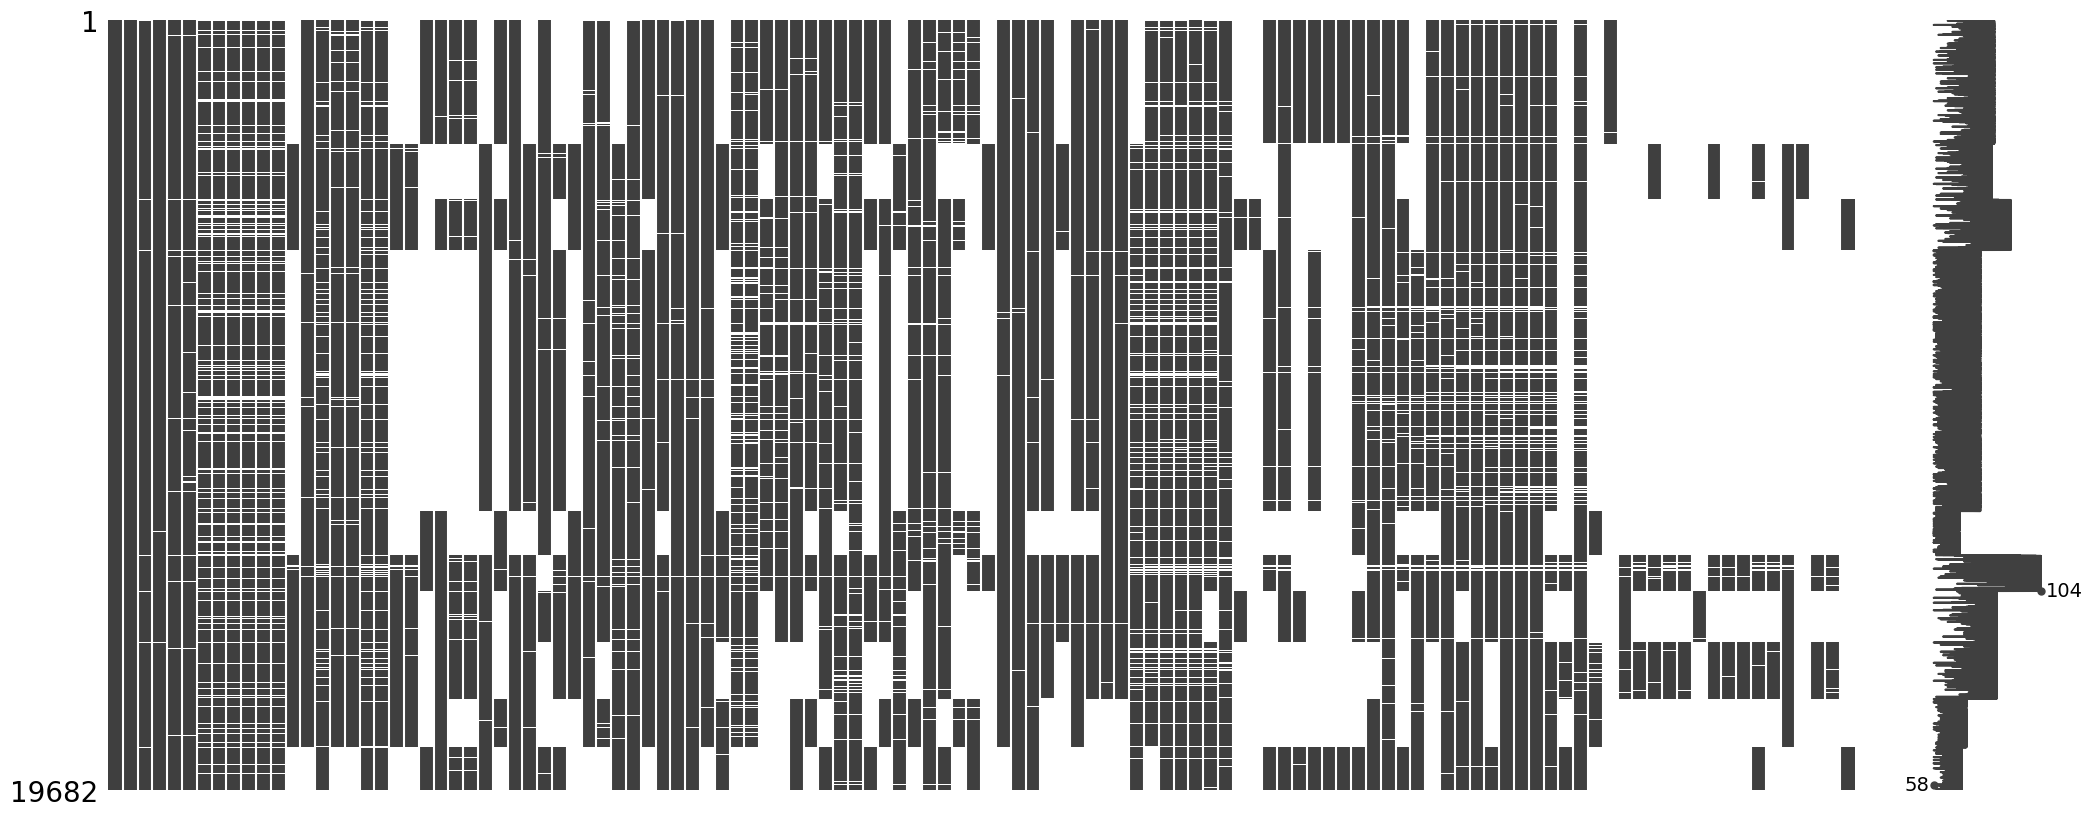

In [7]:
msno.matrix(mental_health_df)

In [8]:
numeric_columns = ['stheight', 'stweight', 'bmi', 'bmipct']
mental_health_df[numeric_columns].describe()

,stheight,stweight,bmi,bmipct
count,17121.000000,17121.000000,17121.000000,1.712100e+04
mean,1.677926,65.487699,23.171922,6.095197e+01
std,0.100418,17.142203,5.325098,2.985224e+01
min,1.300000,29.030000,12.050000,2.970000e-08
25%,1.600000,54.430000,19.630000,3.757000e+01
50%,1.680000,61.240000,21.890000,6.620000e+01
75%,1.750000,72.580000,25.290000,8.818000e+01
max,2.030000,180.990000,62.990000,9.996000e+01


In [9]:
# Get all other columns as categorical (excluding numeric ones)
categorical_columns = [col for col in mental_health_df.columns if col not in numeric_columns]

# Create a summary DataFrame for categorical variables
cat_info = []

for col in categorical_columns:
    cat_info.append([
        col,
        mental_health_df[col].nunique(dropna=False),
        mental_health_df[col].unique(),
        mental_health_df[col].dtype
    ])

df_categorical_info = pd.DataFrame(cat_info, columns=['column_name', 'unique_count', 'unique_values', 'data_type'])

# Show the summary table
print("===== Categorical Variable Summary =====")
print(df_categorical_info)

# Step 3: Print value counts for each categorical variable
print("\n===== Value Counts for Each Categorical Variable =====")
for col in categorical_columns:
    print(f"\n--- {col} ---")
    print(mental_health_df[col].value_counts(dropna=False))

===== Categorical Variable Summary =====
         column_name  unique_count  \
0           sitename            10   
1                age             8   
2                sex             3   
3              grade             5   
4              race4             5   
..               ...           ...   
109     qtransgender             5   
110   qtreatbadlyace             6   
111     qunfairlyace             6   
112  qverbalabuseace             6   
113           qwater             8   

                                         unique_values data_type  
0    [Albuquerque, NM (AB), Chicago, IL (CH), Los A...    object  
1             [nan, 3.0, 4.0, 5.0, 6.0, 7.0, 1.0, 2.0]   float64  
2                                      [nan, 2.0, 1.0]   float64  
3                            [1.0, 2.0, 3.0, 4.0, nan]   float64  
4                            [3.0, nan, 1.0, 4.0, 2.0]   float64  
..                                                 ...       ...  
109                          [nan

In [10]:
gdp_df

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,Real gross domestic product,NaN,NaN,NaN,NaN,Percent change from preceding period,NaN,NaN,NaN
1,NaN,Thousands of chained (2017) dollars,NaN,NaN,NaN,Rank in state,Percent change,NaN,NaN,Rank in state
2,NaN,2020,2021,2022,2023,2023,2021,2022.0,2023.0,2023
3,United States,"20,267,585,000","21,494,798,000","22,034,828,000","22,671,096,000",--,6.1,2.5,2.9,--
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3218,Uinta,"781,034","808,678","836,424","870,000",13,3.5,3.4,4.0,17
3219,Washakie,"342,040","346,039","339,019","347,700",19,1.2,-2.0,2.6,20
3220,Weston,"290,300","295,003","289,622","317,107",21,1.6,-1.8,9.5,6
3221,1. Virginia combination areas consist of one o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
gdp_df.columns

Index(['Table 1. Real Gross Domestic Product, by County, 2020–2023',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [12]:
gdp_df_edited = gdp_df.drop(columns=[
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',  'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

gdp_df_edited = gdp_df_edited[5:]
gdp_df_edited

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 4
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [13]:
#rename first column to 'state' second column to 'gdp 2023' in gdp_df_edited

gdp_df_edited = gdp_df_edited.rename(columns={gdp_df_edited.columns[0]:'state', gdp_df_edited.columns[1]:'gdp 2023'})
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [14]:
mental_health_df['sitename'].unique()

array(['Albuquerque, NM (AB)', 'Chicago, IL (CH)', 'Los Angeles, CA (LO)',
       'New York City, NY (NYC)', 'Oakland, CA (OA)',
       'Philadelphia, PA (PH)', 'Portland, OR (PO)', 'San Diego, CA (SA)',
       'Seattle, WA (SE)', 'Spartanburg County, SC (SP)'], dtype=object)

In [15]:
cities_states = {
    "Albuquerque": "New Mexico",
    "Chicago": "Illinois",
    "Los Angeles": "California",
    "New York City": "New York",
    "Oakland": "California",
    "Philadelphia": "Pennsylvania",
    "Portland": "Oregon",
    "San Diego": "California",
    "Seattle": "Washington",
    "Spartanburg County": "South Carolina"
}

In [16]:
df_mental_health_with_gdp = mental_health_df.copy()

In [17]:
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [18]:
df_mental_health_with_gdp['state'] = df_mental_health_with_gdp['sitename'].apply(lambda x: cities_states[x.split(', ')[0]] if x.split(', ')[0] in cities_states else None)

In [19]:
df_mental_health_with_gdp['gdp 2023'] = df_mental_health_with_gdp['state'].apply(lambda x: gdp_df_edited[gdp_df_edited['state'] == x]['gdp 2023'].values[0] if x is not None else None)

In [20]:
df_mental_health_with_gdp.to_csv('OutputData/mental_health_with_gdp.csv', index=False)

In [21]:
df_mental_health_with_gdp['gdp 2023']

,gdp 2023
0,"110,323,705"
1,"110,323,705"
2,"110,323,705"
3,"110,323,705"
4,"110,323,705"
...,...
22123,"262,298,502"
22124,"262,298,502"
22125,"262,298,502"
22126,"262,298,502"


In [22]:
df = pd.read_csv('OutputData/mental_health_with_gdp.csv')

In [23]:
df.head()

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"


In [24]:
col_info=[]

for col in df.columns:
  col_info.append([col,df[col].nunique(),df[col].unique(),df[col].dtype])

df_cols = pd.DataFrame(col_info, columns=['column_name','unique_num','unique_values','data_type'])
df_cols.head()

,column_name,unique_num,unique_values,data_type
0,sitename,10,"[Albuquerque, NM (AB), Chicago, IL (CH), Los A...",object
1,age,7,"[nan, 3.0, 4.0, 5.0, 6.0, 7.0, 1.0, 2.0]",float64
2,sex,2,"[nan, 2.0, 1.0]",float64
3,grade,4,"[1.0, 2.0, 3.0, 4.0, nan]",float64
4,race4,4,"[3.0, nan, 1.0, 4.0, 2.0]",float64


In [25]:
df_cols.sort_values(by='unique_num', ascending=False)

,column_name,unique_num,unique_values,data_type
9,bmipct,4506,"[nan, 76.67, 55.7, 75.24, 15.48, 72.96, 53.23,...",float64
8,bmi,1662,"[nan, 20.99, 19.15, 20.82, 16.67, 20.58, 18.99...",float64
7,stweight,266,"[nan, 57.15, 52.16, 56.7, 49.9, 66.68, 54.89, ...",float64
6,stheight,30,"[nan, 1.65, 1.73, 1.8, 1.7, 1.6, 1.9, 1.63, 1....",float64
0,sitename,10,"[Albuquerque, NM (AB), Chicago, IL (CH), Los A...",object
...,...,...,...,...
69,q56,2,"[nan, 1.0, 2.0]",float64
103,qincarparentace,2,"[nan, 2.0, 1.0]",float64
110,qsexabuseace,2,"[nan, 2.0, 1.0]",float64
105,qlivedwabuseace,2,"[nan, 2.0, 1.0]",float64


In [26]:
df_states= pd.read_csv('Data/joined_state_data.csv')

In [27]:
df_states

,state,Unemployment Rate(Percent),Mean household income (dollars)
0,Washington,4.5%,"129,161"
1,South Carolina,4.3%,"92,578"
2,Pennsylvania,4.2%,"102,578"
3,Oregon,4.1%,"107,214"
4,New York,5.0%,"122,227"
5,New Mexico,4.8%,"85,782"
6,Illinois,4.7%,"110,930"
7,California,5.5%,"134,491"


In [28]:
df = df.merge(df_states, how='left', on='state')
df.to_csv('OutputData/mental_health_with_socioeconomic_indicators.csv', index=False)
df


,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19677,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.60,54.43,21.26,48.05,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19678,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.50,47.17,20.96,44.14,...,NaN,NaN,NaN,NaN,NaN,4.0,South Carolina,"262,298,502",4.3%,"92,578"
19679,"Spartanburg County, SC (SP)",7.0,1.0,4.0,3.0,4.0,1.50,47.63,21.16,46.85,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19680,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.65,52.16,19.15,19.47,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"


## Handling Missing Data

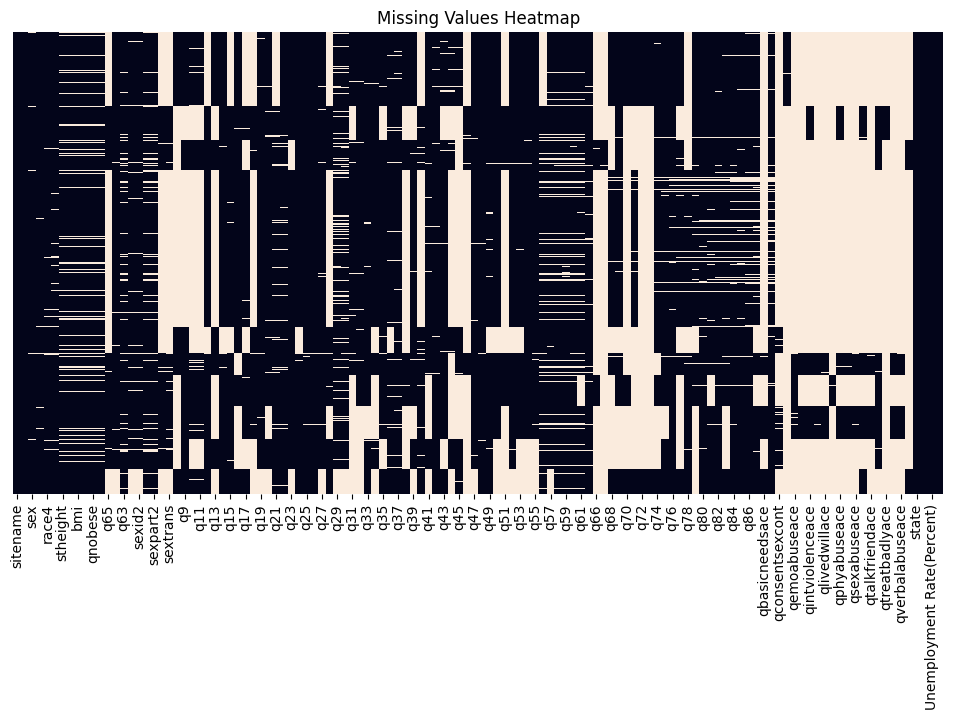

In [29]:
df = pd.read_csv('OutputData/mental_health_with_socioeconomic_indicators.csv')
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [30]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q67                    18409
qparentalmonitoring    18388
qtreatbadlyace         18268
qlivedwillace          17468
qincarparentace        17466
                       ...  
q26                      135
grade                    126
sex                      121
q25                      114
age                       30
Length: 117, dtype: int64


In [31]:
# Set threshold for high missingness (70%)
threshold = 0.70

# Calculate fraction of missing values per column
missing_fraction = df.isnull().mean()

# Identify columns exceeding the threshold
high_missing_cols = missing_fraction[missing_fraction > threshold].index.tolist()

# Print summary
print(f"Columns with >{int(threshold * 100)}% missing values:")
print(high_missing_cols)

# Drop them from the DataFrame
df.drop(columns=high_missing_cols, inplace=True)

print(f"\nDropped {len(high_missing_cols)} columns due to high missingness.")
print(f"Remaining columns: {df.shape[1]}")



Columns with >70% missing values:
['q46', 'q51', 'q66', 'q67', 'q70', 'q72', 'q73', 'qbasicneedsace', 'qconsentsexcont', 'qcurrentopioid', 'qemoabuseace', 'qincarparentace', 'qintviolenceace', 'qlivedwabuseace', 'qlivedwillace', 'qparentalmonitoring', 'qphyabuseace', 'qphyviolenceace', 'qsexabuseace', 'qtalkadultace', 'qtalkfriendace', 'qtreatbadlyace', 'qunfairlyace', 'qverbalabuseace', 'qwater']

Dropped 25 columns due to high missingness.
Remaining columns: 97


In [32]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q44         13435
q8          13391
q45         12573
sextrans    12354
transg      12236
            ...  
q26           135
grade         126
sex           121
q25           114
age            30
Length: 92, dtype: int64


In [33]:
df = df.dropna(subset=['q26'])
df = df.dropna(subset=['q27'])
df = df.dropna(subset=['q84'])
df = df.reset_index(drop=True)

In [34]:
# For each numeric column, calculate the mean and use it to fill missing values.
for col in numeric_columns:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)
    print(f"Filled missing values in '{col}' with mean: {mean_value:.2f}")

Filled missing values in 'stheight' with mean: 1.68
Filled missing values in 'stweight' with mean: 65.21
Filled missing values in 'bmi' with mean: 23.09
Filled missing values in 'bmipct' with mean: 60.41


In [35]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q8       12057
q45      11189
q44      10923
q38      10668
q28       9999
         ...  
q82        125
grade      107
sex        106
q25         84
age         26
Length: 85, dtype: int64


In [36]:
df

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,q84,q85,q86,q87,qclose2people,qtransgender,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,7.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,1.0,1.0,3.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,1.677391,65.20692,23.086023,60.410003,...,1.0,6.0,1.0,1.0,1.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,2.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,4.0,1.0,2.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16934,"Seattle, WA (SE)",7.0,1.0,4.0,3.0,4.0,1.630000,56.70000,21.340000,49.070000,...,5.0,2.0,1.0,2.0,5.0,1.0,Washington,"985,765",4.5%,"129,161"
16935,"Seattle, WA (SE)",7.0,1.0,4.0,2.0,3.0,1.730000,54.43000,18.180000,8.890000,...,2.0,2.0,1.0,1.0,4.0,1.0,Washington,"985,765",4.5%,"129,161"
16936,"Seattle, WA (SE)",7.0,1.0,4.0,NaN,NaN,1.730000,64.41000,21.520000,51.340000,...,4.0,4.0,1.0,1.0,1.0,1.0,Washington,"985,765",4.5%,"129,161"
16937,"Seattle, WA (SE)",7.0,1.0,4.0,1.0,6.0,1.570000,52.16000,21.160000,46.750000,...,5.0,4.0,1.0,1.0,2.0,3.0,Washington,"985,765",4.5%,"129,161"


In [37]:
df.to_csv('OutputData/mental_health_full.csv', index=False)

## EDA

In [38]:
full_df = pd.read_csv('OutputData/mental_health_full.csv')
full_df

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,q84,q85,q86,q87,qclose2people,qtransgender,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,7.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,1.0,1.0,3.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,1.677391,65.20692,23.086023,60.410003,...,1.0,6.0,1.0,1.0,1.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,2.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,4.0,1.0,2.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16934,"Seattle, WA (SE)",7.0,1.0,4.0,3.0,4.0,1.630000,56.70000,21.340000,49.070000,...,5.0,2.0,1.0,2.0,5.0,1.0,Washington,"985,765",4.5%,"129,161"
16935,"Seattle, WA (SE)",7.0,1.0,4.0,2.0,3.0,1.730000,54.43000,18.180000,8.890000,...,2.0,2.0,1.0,1.0,4.0,1.0,Washington,"985,765",4.5%,"129,161"
16936,"Seattle, WA (SE)",7.0,1.0,4.0,NaN,NaN,1.730000,64.41000,21.520000,51.340000,...,4.0,4.0,1.0,1.0,1.0,1.0,Washington,"985,765",4.5%,"129,161"
16937,"Seattle, WA (SE)",7.0,1.0,4.0,1.0,6.0,1.570000,52.16000,21.160000,46.750000,...,5.0,4.0,1.0,1.0,2.0,3.0,Washington,"985,765",4.5%,"129,161"


Shape of dataset: (16939, 97)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16939 entries, 0 to 16938
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sitename                         16939 non-null  object 
 1   age                              16913 non-null  float64
 2   sex                              16833 non-null  float64
 3   grade                            16832 non-null  float64
 4   race4                            16636 non-null  float64
 5   race7                            16472 non-null  float64
 6   stheight                         16939 non-null  float64
 7   stweight                         16939 non-null  float64
 8   bmi                              16939 non-null  float64
 9   bmipct                           16939 non-null  float64
 10  qnobese                          14700 non-null  float64
 11  qnowt                            14700 non-

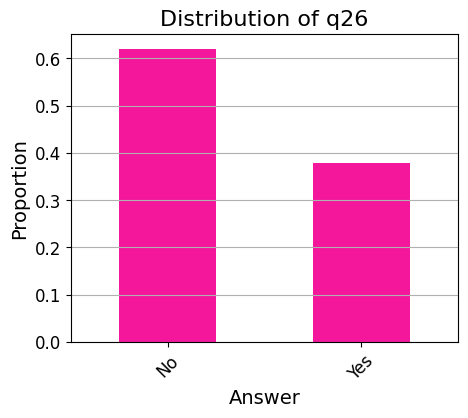

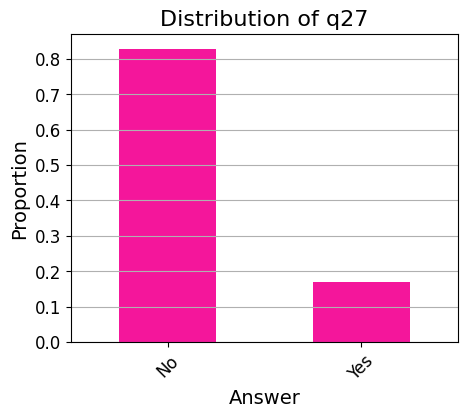

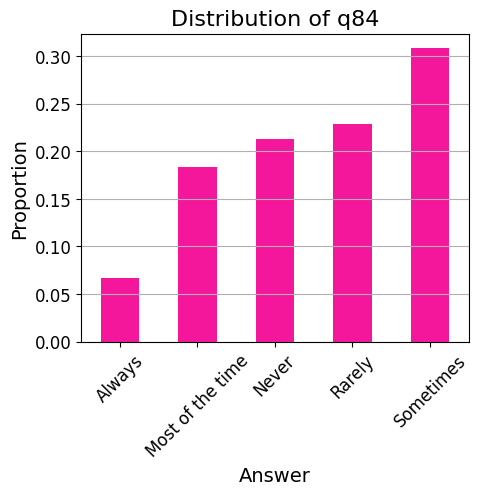

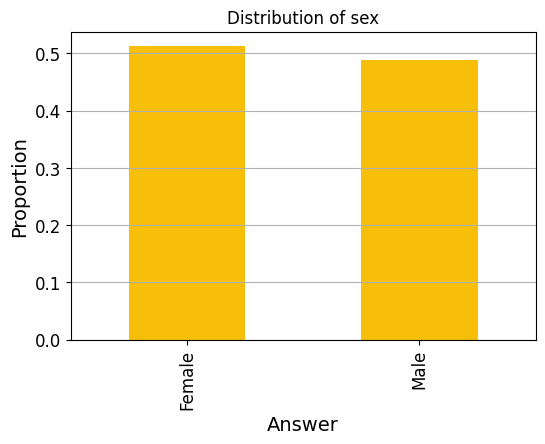

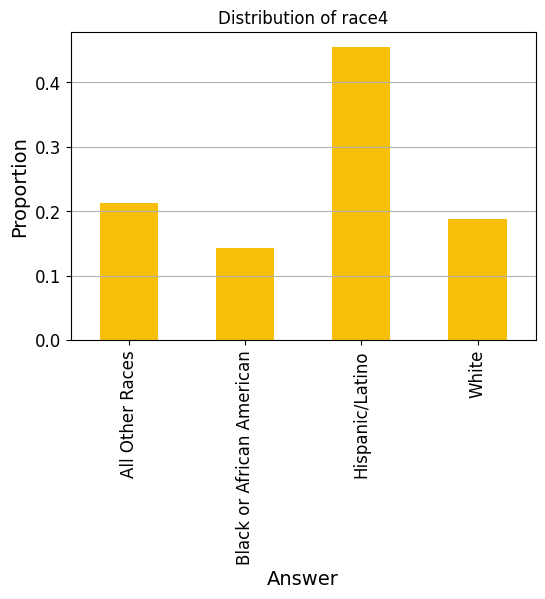

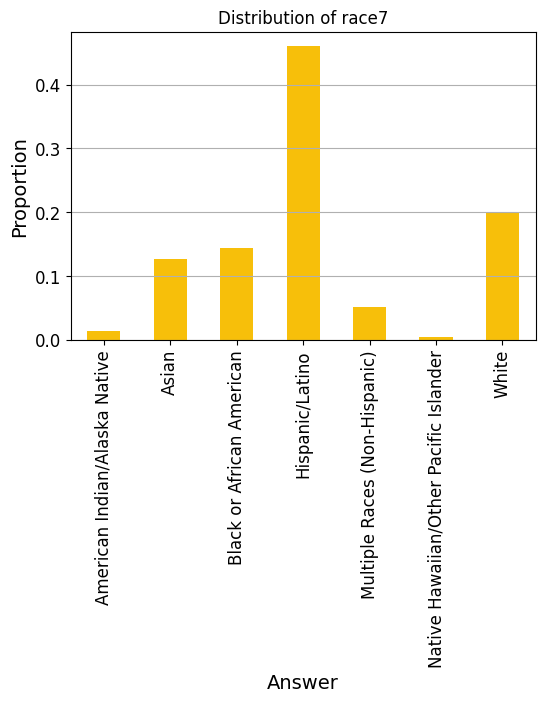

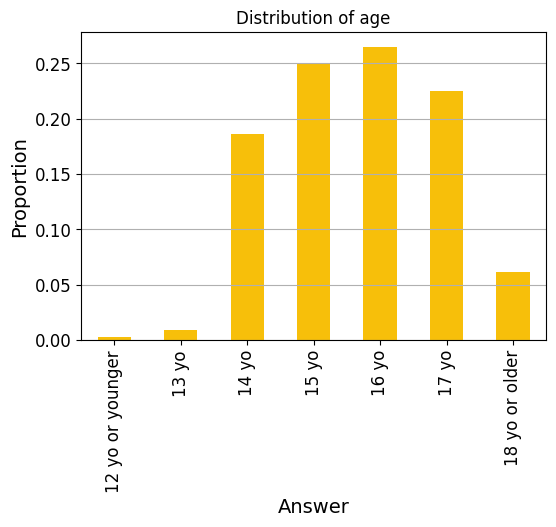

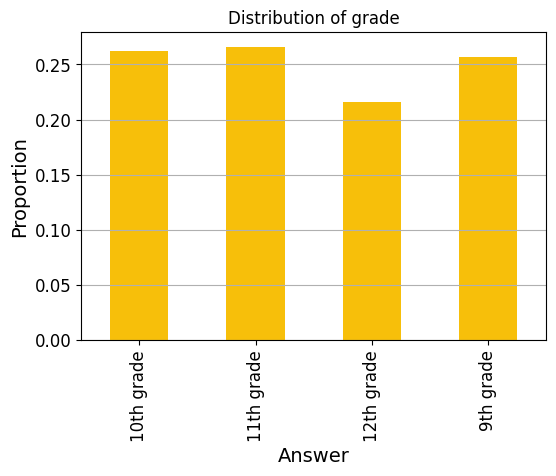

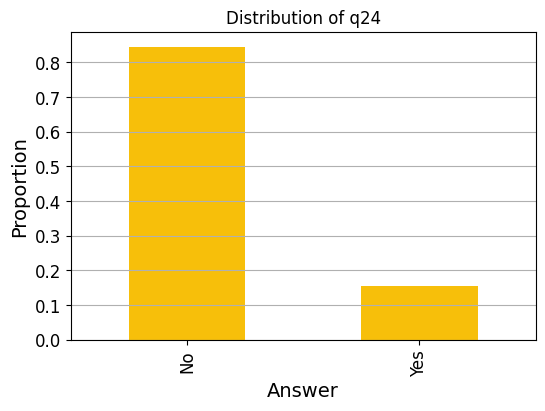

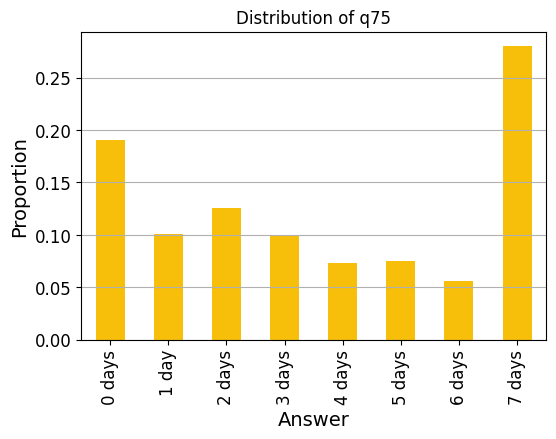

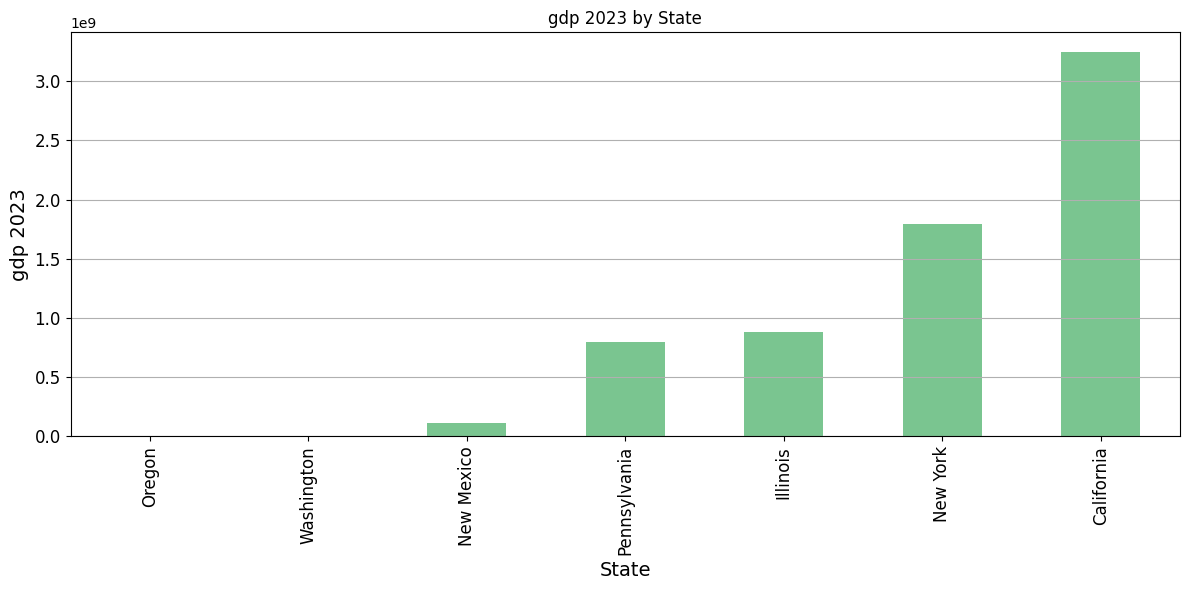

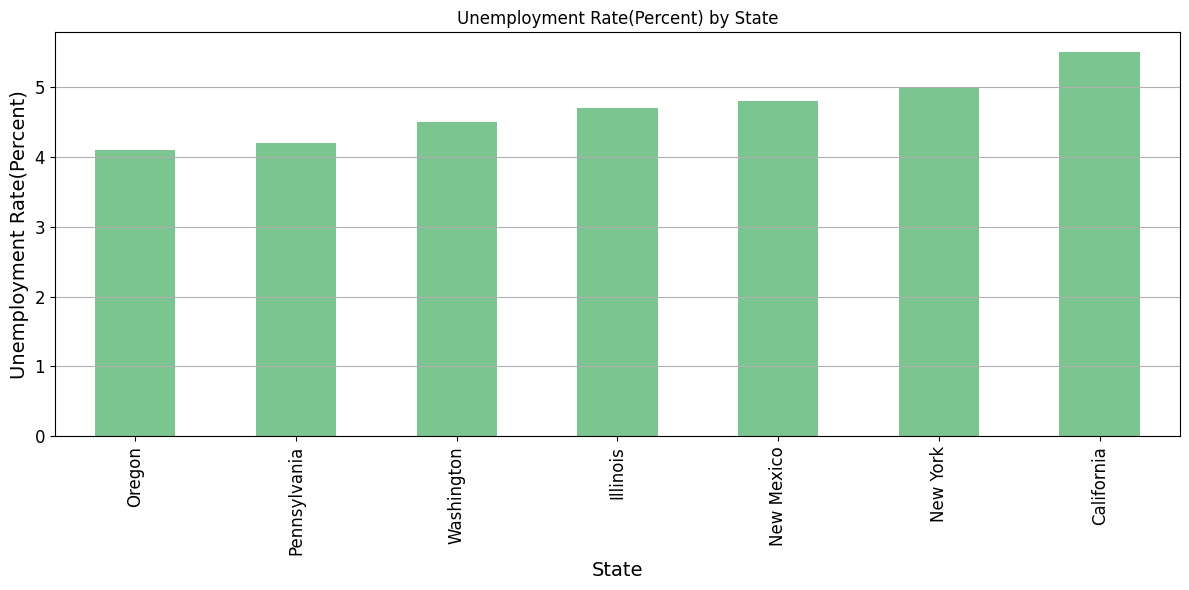

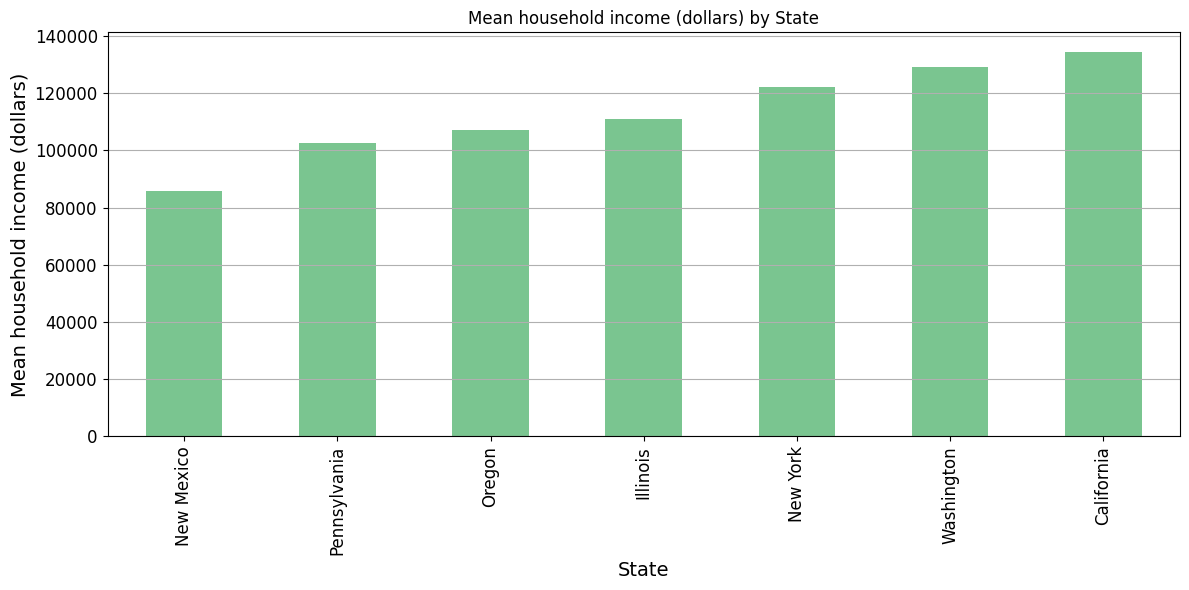

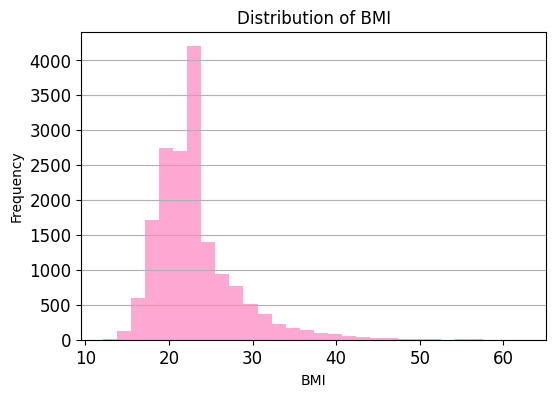

In [39]:
# --- Basic Info ---
print("Shape of dataset:", full_df.shape)
print("\nInfo:")
print(full_df.info())
print("\nSummary statistics:")
print(full_df.describe())

# --- Missing Values ---
print("\nMissing values (sorted):")
missing_percent = full_df.isnull().mean() * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

# --- Mapping dictionaries for key categorical variables ---
mapping_dicts = {
    'q26': {1: 'Yes', 2: 'No'},
    'q27': {1: 'Yes', 2: 'No'},
    'q84': {
        1: 'Never',
        2: 'Rarely',
        3: 'Sometimes',
        4: 'Most of the time',
        5: 'Always'
    },
    'age': {
        1: '12 yo or younger',
        2: '13 yo',
        3: '14 yo',
        4: '15 yo',
        5: '16 yo',
        6: '17 yo',
        7: '18 yo or older'
    },
    'sex': {
        1: 'Female',
        2: 'Male'
    },
    'grade': {
        1: '9th grade',
        2: '10th grade',
        3: '11th grade',
        4: '12th grade',
        5: 'Ungraded or other grade'
    },
    'race4': {
        1: 'White',
        2: 'Black or African American',
        3: 'Hispanic/Latino',
        4: 'All Other Races'
    },
    'race7': {
        1: 'American Indian/Alaska Native',
        2: 'Asian',
        3: 'Black or African American',
        4: 'Hispanic/Latino',
        5: 'Native Hawaiian/Other Pacific Islander',
        6: 'White',
        7: 'Multiple Races (Non-Hispanic)'
    },
    'q24': {
        1: 'Yes',
        2: 'No'
    },
      'q75': {
        1: '0 days',
        2: '1 day',
        3: '2 days',
        4: '3 days',
        5: '4 days',
        6: '5 days',
        7: '6 days',
        8: '7 days'
    }
}

# --- Targets Distribution ---
target_vars = ['q26', 'q27', 'q84']

for target in target_vars:
    if target in full_df.columns:
        if target in mapping_dicts:
            mapped_series = full_df[target].map(mapping_dicts[target])
        else:
            mapped_series = full_df[target]

        if mapped_series.dropna().shape[0] > 0:
            plt.figure(figsize=(5, 4))
            mapped_series.value_counts(normalize=True).sort_index().plot(kind='bar', color='#f4169b')
            plt.title(f'Distribution of {target}', fontsize=16)
            plt.xlabel('Answer', fontsize=14)
            plt.ylabel('Proportion', fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.xticks(rotation=45)
            plt.grid(axis='y')
            plt.show()
        else:
            print(f"Warning: {target} exists but has no non-missing values. Skipping plot.")
    else:
        print(f"Warning: {target} not found in dataset. Skipping plot.")

# --- Additional Categorical Variables Distribution ---
categorical_vars = ['sex', 'race4', 'race7', 'age', 'grade', 'q24', 'q75']

for var in categorical_vars:
    if var in full_df.columns:
        if var in mapping_dicts:
            mapped_series = full_df[var].map(mapping_dicts[var])
        else:
            mapped_series = full_df[var]

        if mapped_series.dropna().shape[0] > 0:
            plt.figure(figsize=(6, 4))
            mapped_series.value_counts(normalize=True).sort_index().plot(kind='bar', color='#f7bf0a')
            plt.title(f'Distribution of {var}')
            plt.xlabel('Answer', fontsize=14)
            plt.ylabel('Proportion', fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.xticks(rotation=90)
            plt.grid(axis='y')
            plt.show()
        else:
            print(f"Warning: {var} exists but has no non-missing values. Skipping plot.")
    else:
        print(f"Warning: {var} not found in dataset. Skipping plot.")


# Clean the numeric columns if they contain commas or percentage signs (only run once)
full_df['gdp 2023'] = full_df['gdp 2023'].astype(str).str.replace(',', '').astype(float)
full_df['Unemployment Rate(Percent)'] = full_df['Unemployment Rate(Percent)'].astype(str).str.replace('%', '').astype(float)
full_df['Mean household income (dollars)'] = full_df['Mean household income (dollars)'].astype(str).str.replace(',', '').astype(float)

# Columns to plot
columns_to_plot = ['gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Plot each variable
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    full_df.groupby('state')[column].mean().sort_values().plot(kind='bar', color='#7ac590')
    plt.title(f"{column} by State")
    plt.xlabel("State", fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


# --- Histogram for BMI ---
if 'bmi' in full_df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(full_df['bmi'].dropna(), bins=30, color='#ffa8d3')
    plt.title('Distribution of BMI')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y')
    plt.show()
else:
    print("Feature 'bmi' not found.")


## Outliers

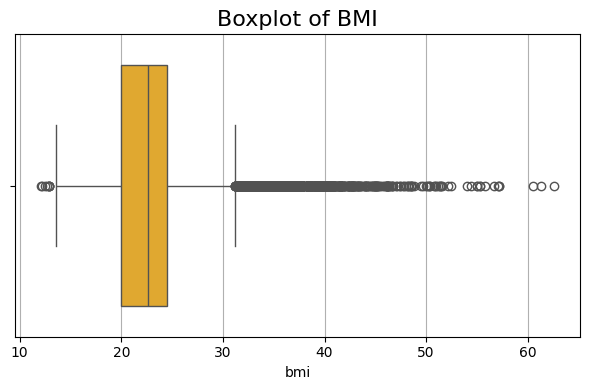

Number of BMI outliers: 1124 (6.64%)


In [40]:
# --- 1. Visualize BMI with a boxplot ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=full_df, x='bmi', color='#feb312')
plt.title('Boxplot of BMI', fontsize=16)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --- 2. Detect outliers using IQR ---
Q1 = full_df['bmi'].quantile(0.25)
Q3 = full_df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask of outliers
bmi_outliers = (full_df['bmi'] < lower_bound) | (full_df['bmi'] > upper_bound)

# Print outlier count
outlier_count = bmi_outliers.sum()
print(f"Number of BMI outliers: {outlier_count} ({round(100 * outlier_count / len(full_df), 2)}%)")

In [41]:
# Prepare contingency table for q27 by BMI outlier status
# First, re-calculate IQR outlier flag for BMI
Q1 = full_df['bmi'].quantile(0.25)
Q3 = full_df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
full_df['bmi_outlier'] = full_df['bmi'].apply(lambda x: 'Outlier' if x < lower_bound or x > upper_bound else 'Normal')

# Prepare the contingency table (drop missing q27 values)
contingency = pd.crosstab(full_df['bmi_outlier'], full_df['q27'])

# Run chi-square test
chi2, p, dof, expected = st.chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}")
print(f"p-value = {p:.4f}")
print("Result: Significant association" if p < 0.05 else "Result: Not significant")

Chi² = 5.05
p-value = 0.0246
Result: Significant association


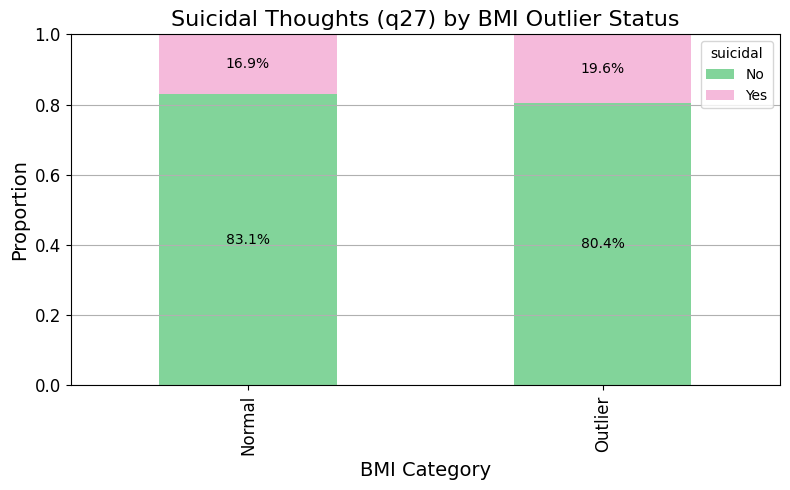

In [42]:
# Prepare data
suicide_map = {1: 'Yes', 2: 'No'}
temp = full_df[['bmi_outlier', 'q27']].copy()
temp['suicidal'] = temp['q27'].map(suicide_map)
temp.dropna(inplace=True)

# Calculate proportions
suicide_rate = pd.crosstab(temp['bmi_outlier'], temp['suicidal'], normalize='index')

colors = ['#82d49a', '#f5badb']

# Plot
ax = suicide_rate.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors)
plt.title('Suicidal Thoughts (q27) by BMI Outlier Status', fontsize=16)
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()

# Add percentage labels
for i, bars in enumerate(ax.containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # skip very small bars
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1%}",
                ha='center',
                va='center',
                fontsize=10,
                color='black'
            )

plt.show()


## Bivariate/Multivariate Analysis

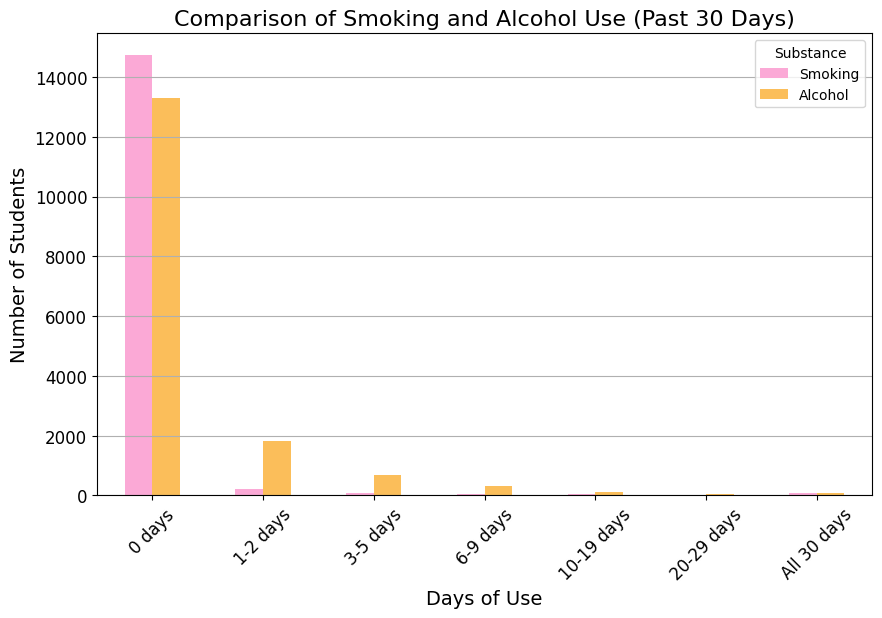

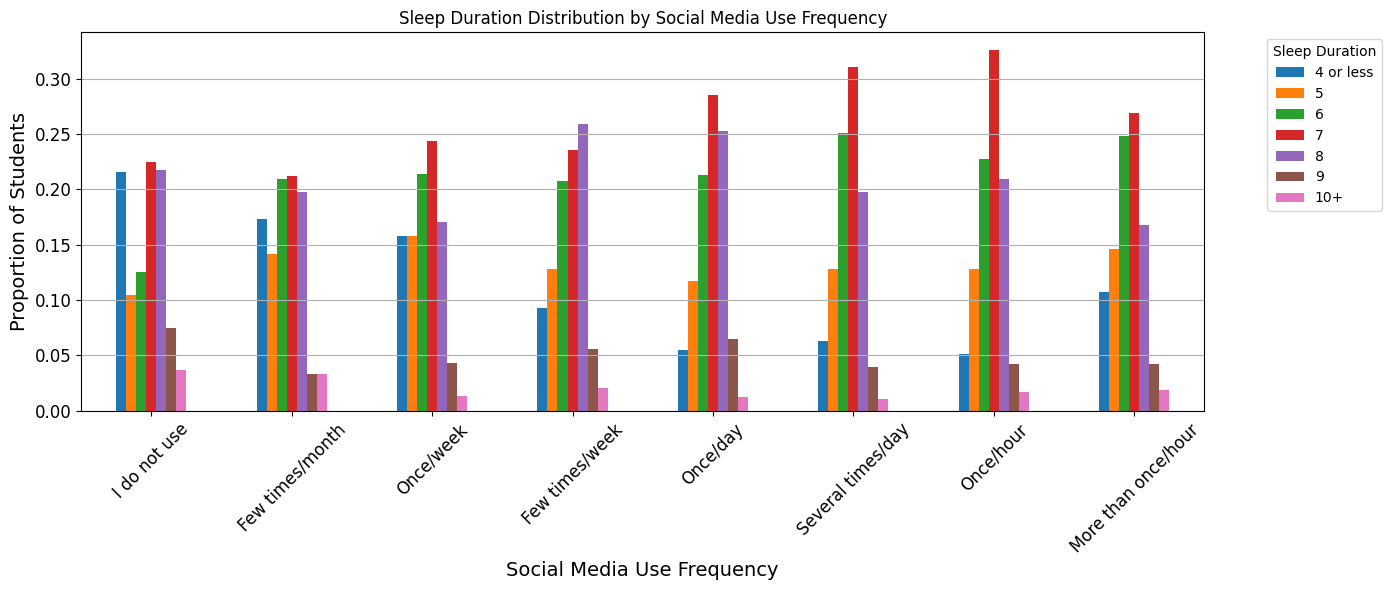

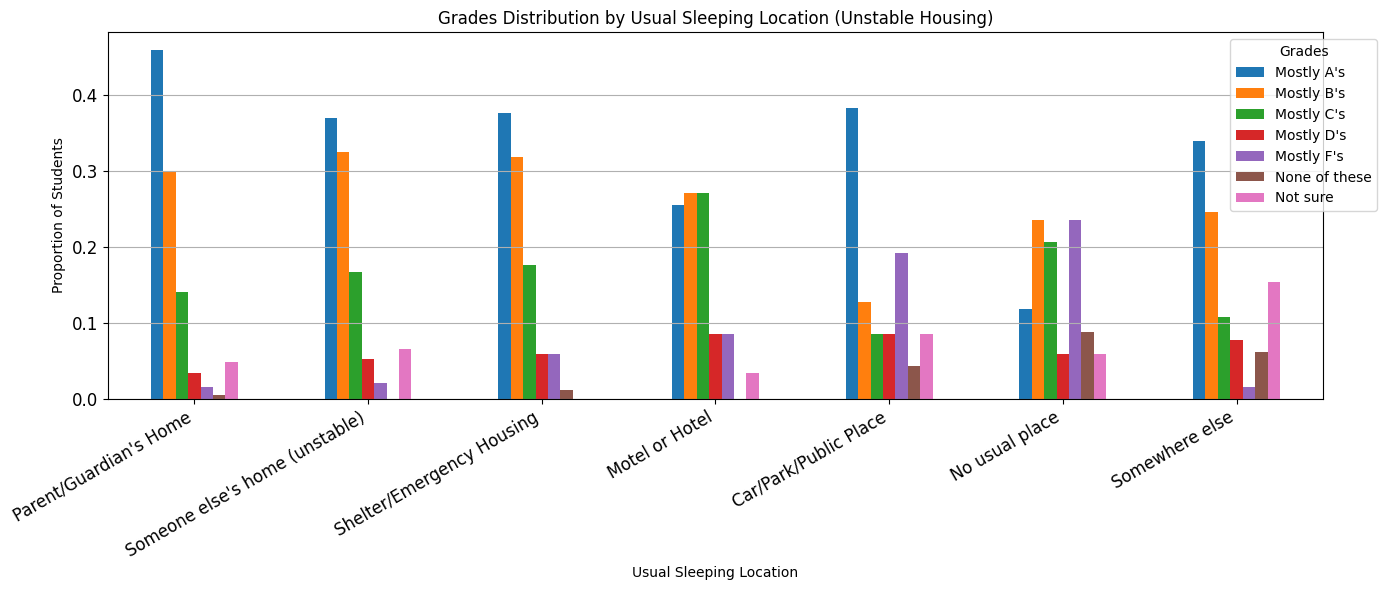

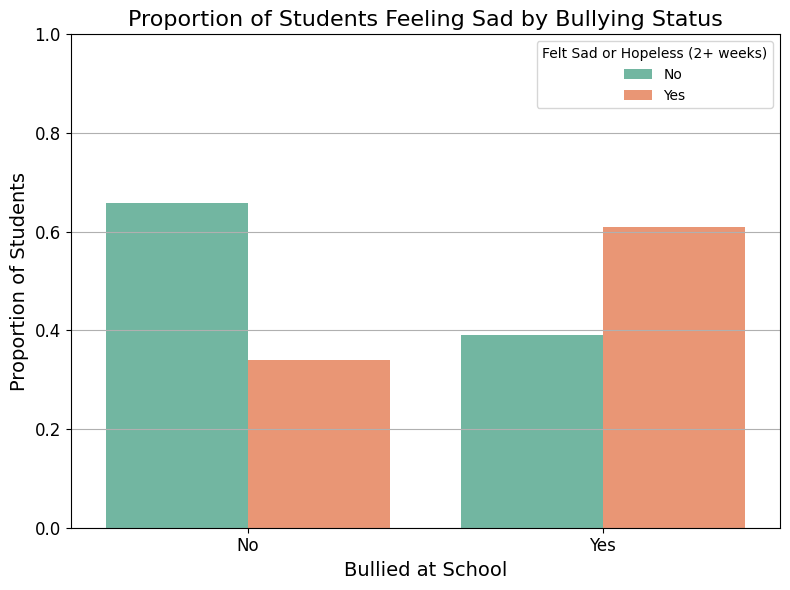

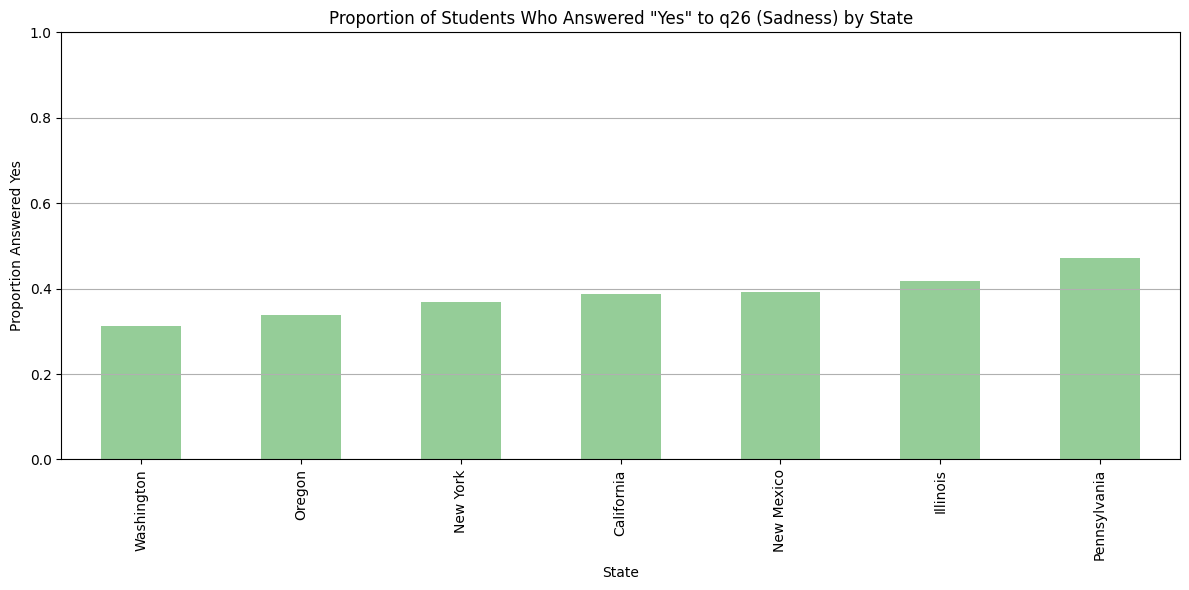

In [43]:
# --- Mapping dictionary ---
smoking_drinking_mapping = {
    1: '0 days',
    2: '1-2 days',
    3: '3-5 days',
    4: '6-9 days',
    5: '10-19 days',
    6: '20-29 days',
    7: 'All 30 days'
}

# --- Map temporarily ---
q33_mapped = full_df['q33'].map(smoking_drinking_mapping)
q42_mapped = full_df['q42'].map(smoking_drinking_mapping)

# --- Calculate counts ---
smoking_counts = q33_mapped.value_counts().reindex(smoking_drinking_mapping.values(), fill_value=0)
alcohol_counts = q42_mapped.value_counts().reindex(smoking_drinking_mapping.values(), fill_value=0)

# --- Create dataframe ---
counts_df = pd.DataFrame({
    'Smoking': smoking_counts,
    'Alcohol': alcohol_counts
}, index=smoking_drinking_mapping.values())

colors1 = ['#fba9d6', '#fbbe5a']

# --- Plot Grouped Bar Plot ---
counts_df.plot(kind='bar', figsize=(10,6), color=colors1)
plt.title('Comparison of Smoking and Alcohol Use (Past 30 Days)', fontsize=16)
plt.xlabel('Days of Use', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Substance')
plt.grid(axis='y')
plt.show()

# --- Define mappings ---
social_media_mapping = {
    1: 'I do not use',
    2: 'Few times/month',
    3: 'Once/week',
    4: 'Few times/week',
    5: 'Once/day',
    6: 'Several times/day',
    7: 'Once/hour',
    8: 'More than once/hour'
}

sleep_mapping = {
    1: '4 or less',
    2: '5',
    3: '6',
    4: '7',
    5: '8',
    6: '9',
    7: '10+'
}

# --- Temporary dataframe ---
df_temp = full_df[['q80', 'q85']].copy()
df_temp['social_media'] = df_temp['q80'].map(social_media_mapping)
df_temp['sleep'] = df_temp['q85'].map(sleep_mapping)
df_temp.dropna(inplace=True)

# --- Define proper category orders ---
social_order = list(social_media_mapping.values())
sleep_order = list(sleep_mapping.values())

# --- Create cross-tabulation ---
cross_tab = pd.crosstab(df_temp['social_media'], df_temp['sleep'], normalize='index')
cross_tab = cross_tab.reindex(index=social_order, columns=sleep_order)

# --- Plot grouped bar chart ---
cross_tab.plot(kind='bar', figsize=(14,6))
plt.title('Sleep Duration Distribution by Social Media Use Frequency')
plt.xlabel('Social Media Use Frequency', fontsize=14)
plt.ylabel('Proportion of Students', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sleep Duration', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Mapping dictionaries ---
grades_mapping = {
    1: "Mostly A's",
    2: "Mostly B's",
    3: "Mostly C's",
    4: "Mostly D's",
    5: "Mostly F's",
    6: "None of these",
    7: "Not sure"
}

housing_mapping = {
    1: "Parent/Guardian's Home",
    2: "Someone else's home (unstable)",
    3: "Shelter/Emergency Housing",
    4: "Motel or Hotel",
    5: "Car/Park/Public Place",
    6: "No usual place",
    7: "Somewhere else"
}

# --- Map variables ---
df_temp = full_df[['q87', 'q86']].copy()
df_temp['grades'] = df_temp['q87'].map(grades_mapping)
df_temp['housing'] = df_temp['q86'].map(housing_mapping)
df_temp.dropna(inplace=True)

# --- Define display order ---
grade_order = list(grades_mapping.values())
housing_order = list(housing_mapping.values())

# --- Cross-tabulation normalized by row ---
cross_tab = pd.crosstab(df_temp['housing'], df_temp['grades'], normalize='index')
cross_tab = cross_tab[grade_order]
cross_tab = cross_tab.reindex(housing_order)

# --- Plot ---
cross_tab.plot(kind='bar', figsize=(14,6))
plt.title('Grades Distribution by Usual Sleeping Location (Unstable Housing)')
plt.xlabel('Usual Sleeping Location')
plt.ylabel('Proportion of Students')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.legend(title='Grades', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Mapping ---
bullying_mapping = {1: 'Yes', 2: 'No'}
sadness_mapping = {1: 'Yes', 2: 'No'}

# --- Prepare Data ---
df_temp = full_df[['q24', 'q26']].copy()
df_temp['bullied'] = df_temp['q24'].map(bullying_mapping)
df_temp['sad'] = df_temp['q26'].map(sadness_mapping)
df_temp.dropna(inplace=True)

# --- Count and Normalize ---
grouped = df_temp.groupby(['bullied', 'sad']).size().reset_index(name='count')
grouped['proportion'] = grouped.groupby('bullied')['count'].transform(lambda x: x / x.sum())

# --- Plot Grouped Bar Chart ---
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped, x='bullied', y='proportion', hue='sad', palette='Set2')
plt.title('Proportion of Students Feeling Sad by Bullying Status', fontsize=16)
plt.xlabel('Bullied at School', fontsize=14)
plt.ylabel('Proportion of Students', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Felt Sad or Hopeless (2+ weeks)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Step 1: Filter out rows with missing or invalid q26/state
filtered_df = full_df[(full_df['q26'].isin([1, 2])) & (full_df['state'].notnull())]

# Step 2: Calculate proportion of "Yes" answers per state
yes_proportion = (
    filtered_df.groupby('state')['q26']
    .apply(lambda x: (x == 1).mean())
    .sort_values()
)

# Step 3: Plot the result
plt.figure(figsize=(12, 6))
yes_proportion.plot(kind='bar', color='#95cd98')
plt.title('Proportion of Students Who Answered "Yes" to q26 (Sadness) by State')
plt.xlabel('State')
plt.ylabel('Proportion Answered Yes')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipython-input-44-3124143233.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hot')  # or any sequential map like 'viridis', 'Blues', etc.


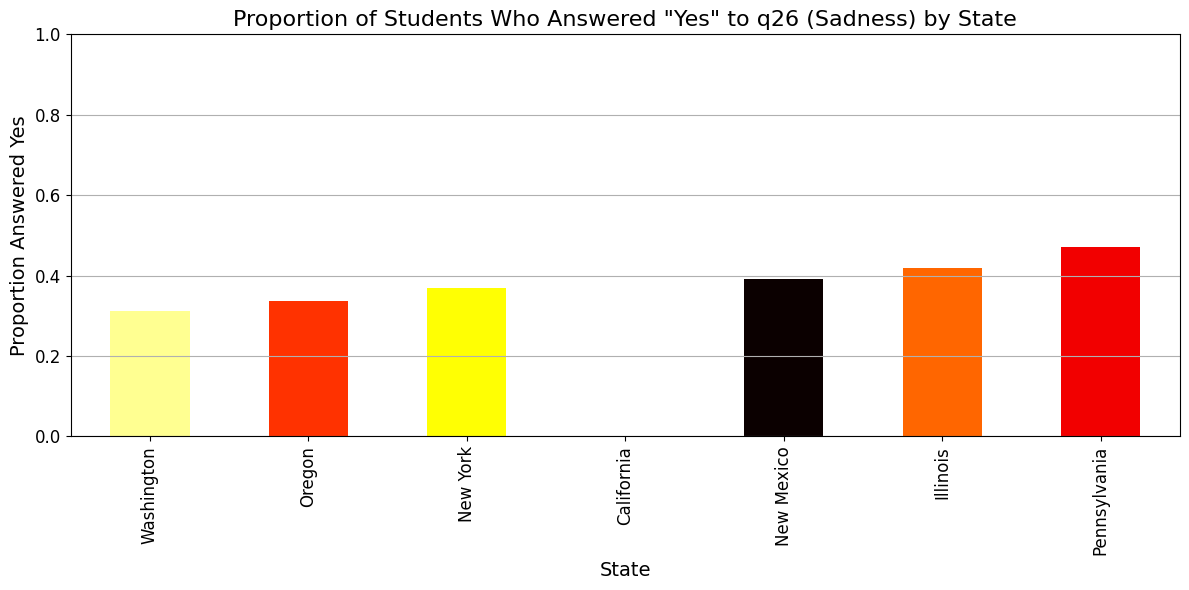

In [44]:
# Step 1: Filter out rows with missing or invalid q26/state
filtered_df = full_df[(full_df['q26'].isin([1, 2])) & (full_df['state'].notnull())]

# Step 2: Calculate proportion of "Yes" answers per state
yes_proportion = (
    filtered_df.groupby('state')['q26']
    .apply(lambda x: (x == 1).mean())
    .sort_values()
)

# Step 3: Get average income per state (in same order as yes_proportion)
income_by_state = (
    filtered_df.groupby('state')['Mean household income (dollars)']
    .mean()
)
income_by_state = income_by_state.loc[yes_proportion.index]  # align with sorted states

# Step 4: Create sequential color scale from income
norm = mcolors.Normalize(vmin=income_by_state.min(), vmax=income_by_state.max())
cmap = cm.get_cmap('hot')  # or any sequential map like 'viridis', 'Blues', etc.
bar_colors = [cmap(norm(val)) for val in income_by_state]

# Step 5: Plot the result
plt.figure(figsize=(12, 6))
yes_proportion.plot(kind='bar', color=bar_colors)
plt.title('Proportion of Students Who Answered "Yes" to q26 (Sadness) by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Proportion Answered Yes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Identifying Redundant Categorical Variables Using Cramer's V

In [45]:
target_col = 'q26'
numeric_vars = ['stheight', 'stweight', 'bmi', 'bmipct', 'gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']
nonrelevant_vars = ['q27', 'q84', 'record', 'sitename', 'state']
cat_vars = [col for col in full_df.columns if col not in numeric_vars and col != target_col and col not in nonrelevant_vars]

# Function to compute Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Threshold for redundancy
threshold = 0.85
results = []

# Compute and store results
for col1, col2 in tqdm(combinations(cat_vars, 2), total=(len(cat_vars)*(len(cat_vars)-1))//2):
    v = cramers_v(full_df[col1], full_df[col2])
    if v is not None and v > threshold:
        results.append((col1, col2, v))

# Sort results by Cramer's V descending
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)

# Display
print("\nHighly correlated categorical pairs (Cramer's V > 0.85):\n")
for col1, col2, v in results_sorted:
    print(f"{col1} ↔ {col2} : Cramer's V = {v:.3f}")


100%|██████████| 3655/3655 [00:29<00:00, 124.78it/s]


Highly correlated categorical pairs (Cramer's V > 0.85):

q65 ↔ transg : Cramer's V = 1.000
q65 ↔ qtransgender : Cramer's V = 1.000
q64 ↔ sexid : Cramer's V = 1.000
transg ↔ qtransgender : Cramer's V = 1.000
sexpart ↔ sexpart2 : Cramer's V = 1.000
q56 ↔ q60 : Cramer's V = 1.000
q56 ↔ q61 : Cramer's V = 1.000
q64 ↔ sexid2 : Cramer's V = 1.000
sexid ↔ sexid2 : Cramer's V = 1.000
q56 ↔ q58 : Cramer's V = 1.000
q31 ↔ q32 : Cramer's V = 1.000
q56 ↔ q57 : Cramer's V = 1.000
q56 ↔ q59 : Cramer's V = 1.000
sexid2 ↔ sextrans : Cramer's V = 0.991
sexid ↔ sextrans : Cramer's V = 0.991
q64 ↔ sextrans : Cramer's V = 0.991
race4 ↔ race7 : Cramer's V = 0.984
q56 ↔ q62 : Cramer's V = 0.941
q63 ↔ sexpart2 : Cramer's V = 0.864


In [46]:
# Drop redundant variables
redundant_vars = ['sexid2', 'q64', 'sexpart2', 'q63', 'bmi', 'stheight', 'stweight', 'qnobese', 'qnowt']
full_df.drop(columns=redundant_vars, inplace=True)

## Encoding

In [47]:
vars_to_dummy = [
    'age', 'sex', 'grade', 'race4', 'race7', 'q65', 'sexid', 'sexpart', 'transg', 'sextrans',
    'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17',
    'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29',
    'q30', 'q31', 'q32', 'q33', 'q34', 'q35', 'q36', 'q37', 'q38', 'q39',
    'q40', 'q41', 'q42', 'q43', 'q44', 'q45', 'q47', 'q48', 'q49', 'q50',
    'q52', 'q53', 'q54', 'q55', 'q56', 'q57', 'q58', 'q59', 'q60', 'q61',
    'q62', 'q68', 'q69', 'q71', 'q74', 'q75', 'q76', 'q77', 'q78', 'q79',
    'q80', 'q81', 'q82', 'q83', 'q85', 'q86', 'q87', 'qclose2people', 'qtransgender'
]

# Create binary version of q84
full_df['q84_binary'] = full_df['q84'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})

for var in vars_to_dummy:
    unique_vals = full_df[var].dropna().unique()

    #If the variable is binary with values 1 and 2 only
    if sorted(unique_vals) == [1, 2]:
        full_df[var] = full_df[var].replace({1: 1, 2: 0})

    else:
        #Variables with more than two categories → dummy encoding
        dummies = pd.get_dummies(full_df[var], prefix=var, dummy_na=False, drop_first=True)
        full_df = pd.concat([full_df, dummies], axis=1)
        full_df.drop(columns=[var], inplace=True)

In [48]:
# Rename features for cleaner plots and outputs
feature_labels = {
    'sex': "Sex",
    'q35': "Electronic vapor product use",
    'sextrans': "Sexual and gender identity",
    'q18': "Saw physical violence in neighborhood",
    'q19': "Forced sexual intercourse",
    'q56': "Ever had sexual intercourse",
    'q25': "Electronic bullying (past 12 months)",
    'q24': "Bullying at school (past 12 months)",
    'q31': "Ever smoked a cigarette",
    'bmipct': "BMI percentile",
    'Mean household income (dollars)': "Mean household income"
}

## Q26

In [49]:
## hereeeeeeeeeeeeeeeeeeee

df_26 = full_df[full_df['q26'].isin([0, 1])].copy()
df_26['target'] = df_26['q26']

# Step 2: Drop irrelevant columns
X26 = df_26.drop(columns=['q26', 'q27', 'q84', 'q84_binary', 'target', 'state', 'sitename', 'q28'])
y26 = df_26['target']

X26 = X26.select_dtypes(include=[float, int]).dropna()
y26 = y26.loc[X26.index]

# print('types of features in X')
print('x.shape ', X26.shape)
print('y.shape ', y26.shape)

X26_train, X26_test, y26_train, y26_test = train_test_split(
    X26, y26, test_size=0.3, random_state=42, stratify=y26
)

numeric_columns = ['bmipct', 'gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Step 4: Scale features
scaler = StandardScaler()
X26_train[numeric_columns] = scaler.fit_transform(X26_train[numeric_columns])
X26_test[numeric_columns] = scaler.transform(X26_test[numeric_columns])


x.shape  (1604, 13)
y.shape  (1604,)


## Simple Predictive Baseline

### Constant baseline model

In [50]:
# --- Constant baseline model (predicting most frequent class) ---
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X26_train, y26_train)

# --- Predictions ---
y_train_pred = dummy.predict(X26_train)
y_test_pred = dummy.predict(X26_test)

# --- Evaluation ---
print("Constant Baseline for q26")
print("Train Accuracy:", accuracy_score(y26_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y26_test, y_test_pred))

Constant Baseline for q26
Train Accuracy: 0.5721925133689839
Test Accuracy: 0.5726141078838174


### Univariate Logistic Regression

In [51]:
# Step 1: Drop missing values for q26 and q24
df_uni = full_df.dropna(subset=['q26', 'q24']).copy()

# Step 2: Select numeric q24 and binary q26
df_uni = df_uni[df_uni['q26'].isin([0, 1])]

# Step 3: Set predictor and target
X_uni = df_uni[['q24']]
y_uni = df_uni['q26']

# Step 4: Train/test split
X_uni_train, X_uni_test, y_uni_train, y_uni_test = train_test_split(
    X_uni, y_uni, test_size=0.3, random_state=42, stratify=y_uni
)

# Step 5: Scale q24
scaler_uni = StandardScaler()
X_uni_train_scaled = scaler_uni.fit_transform(X_uni_train)
X_uni_test_scaled = scaler_uni.transform(X_uni_test)

# Step 6: Train logistic regression model
model_uni = LogisticRegression(solver='liblinear')
model_uni.fit(X_uni_train_scaled, y_uni_train)

# Step 7: Predictions
y_uni_train_pred = model_uni.predict(X_uni_train_scaled)
y_uni_test_pred = model_uni.predict(X_uni_test_scaled)

# Step 8: Evaluation
print("Univariate Logistic Regression: q24 → q26")
print("Train Accuracy:", accuracy_score(y_uni_train, y_uni_train_pred))
print("Test Accuracy:", accuracy_score(y_uni_test, y_uni_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_uni_test, y_uni_test_pred, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0 (No Sadness)", "Predicted 1 (Yes Sadness)"]
)
print("\nConfusion Matrix (Test):\n", cm_df)


Univariate Logistic Regression: q24 → q26
Train Accuracy: 0.6477355072463769
Test Accuracy: 0.6595519864750634

Confusion Matrix (Test):
                         Predicted 0 (No Sadness)  Predicted 1 (Yes Sadness)
Actual 0 (No Sadness)                       2661                        262
Actual 1 (Yes Sadness)                      1349                        460


## Sparse Logistic Regression

/tmp/ipython-input-52-1313874952.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')


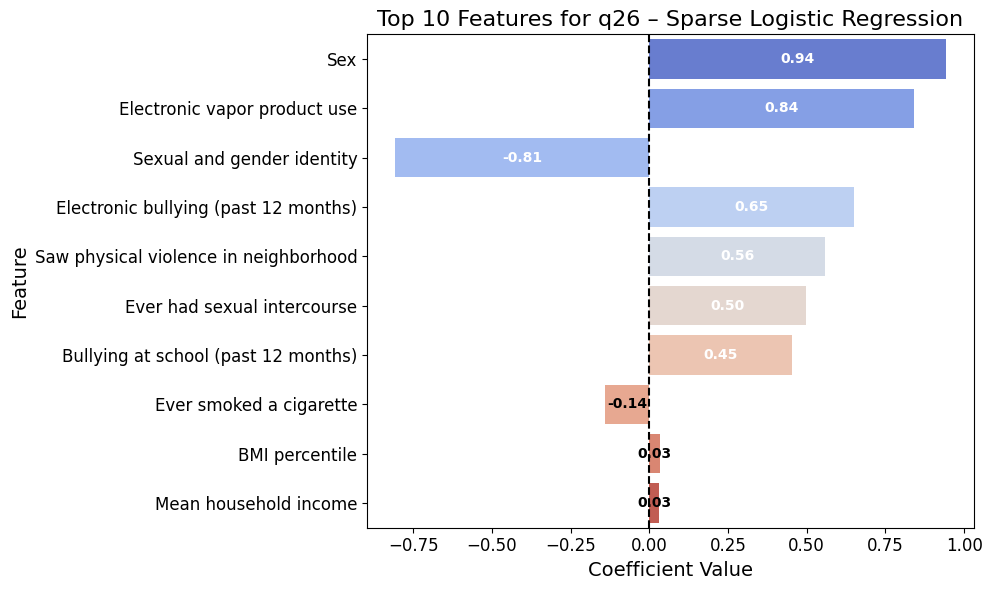

Cross-Validation (20-fold):
Accuracy: 0.6882 ± 0.0177
Log Loss: 0.5836 ± 0.0189

Test Set Performance:
Accuracy: 0.6763
Log Loss: 0.5999

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           207           69
Actual 1 (Yes Sadness)           87          119

False Positive Rate (FPR): 0.2500
False Negative Rate (FNR): 0.4223


In [52]:
# Step 6: Train final model on train set (used for interpretation only!)
model_slr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
model_slr.fit(X26_train, y26_train)

# Store feature names and coefficients before any overwriting
final_coef_slr = model_slr.coef_[0]
final_features_slr = X26.columns

# Step 12: Top 10 features (based on model trained before CV)
coef_df_slr = pd.DataFrame({
    'Feature': final_features_slr,
    'Coefficient': final_coef_slr
})
non_zero_slr = coef_df_slr[coef_df_slr['Coefficient'] != 0]
top_features_slr = non_zero_slr.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
top_features_slr['Label'] = top_features_slr['Feature'].map(feature_labels).fillna(top_features_slr['Feature'])

# Step 13: Plot top features
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')
for i, (value, name) in enumerate(zip(top_features_slr['Coefficient'], top_features_slr['Label'])):
    ax.text(value / 2, i, f"{value:.2f}",
            color='white' if abs(value) > 0.4 else 'black',
            ha='center', va='center', fontweight='bold')

plt.title('Top 10 Features for q26 – Sparse Logistic Regression', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# ------------------ Evaluation Metrics ------------------ #

# --- 1. Cross-Validation Accuracy and Log Loss with CI --- #
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

cv_accuracy_scores = cross_val_score(model_slr, X26_train, y26_train, cv=cv, scoring='accuracy')
cv_logloss_scores = cross_val_score(model_slr, X26_train, y26_train, cv=cv, scoring='neg_log_loss')

# Convert log loss scores to positive
cv_logloss_scores = -cv_logloss_scores

# 95% Confidence Intervals
acc_ci = st.t.interval(0.95, len(cv_accuracy_scores)-1, loc=np.mean(cv_accuracy_scores), scale=st.sem(cv_accuracy_scores))
logloss_ci = st.t.interval(0.95, len(cv_logloss_scores)-1, loc=np.mean(cv_logloss_scores), scale=st.sem(cv_logloss_scores))

print("Cross-Validation (20-fold):")
print(f"Accuracy: {np.mean(cv_accuracy_scores):.4f} ± {st.sem(cv_accuracy_scores):.4f}")
print(f"Log Loss: {np.mean(cv_logloss_scores):.4f} ± {st.sem(cv_logloss_scores):.4f}")

# --- 2. Test Accuracy and Log Loss --- #
y26_pred = model_slr.predict(X26_test)
y26_proba = model_slr.predict_proba(X26_test)[:, 1]

test_accuracy = accuracy_score(y26_test, y26_pred)
test_logloss = log_loss(y26_test, y26_proba)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Log Loss: {test_logloss:.4f}")

# --- 3. Confusion Matrix + FPR, FNR --- #
# Compute confusion matrix
conf_matrix = confusion_matrix(y26_test, y26_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Format into DataFrame
conf_df = pd.DataFrame(
    conf_matrix,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

# Print results
print("\nConfusion Matrix:")
print(conf_df)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")



## Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest with RandomizedSearchCV
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 16}


/tmp/ipython-input-53-3260876547.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')
/tmp/ipython-input-53-3260876547.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')


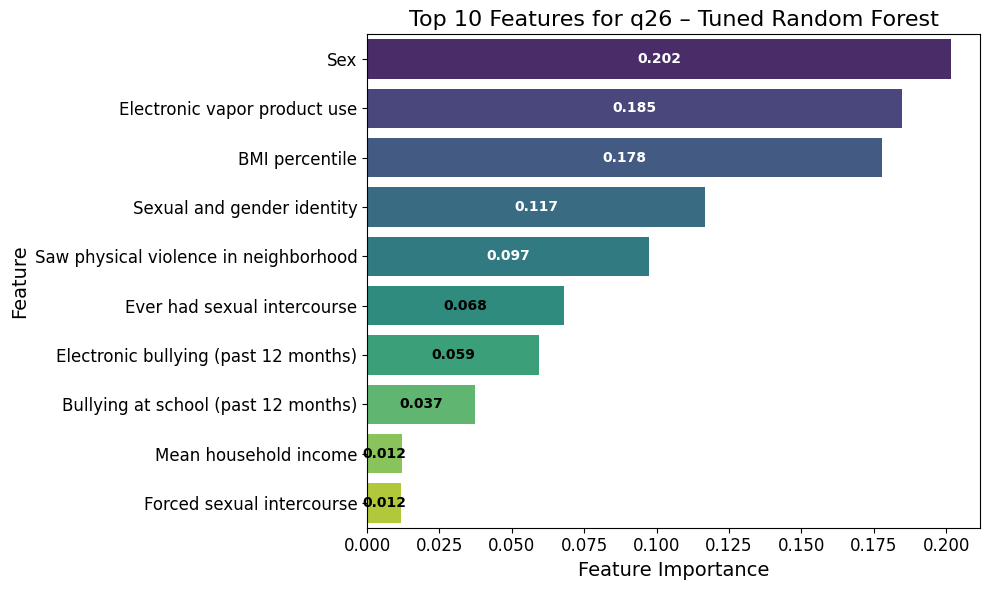


Cross-Validation (20-fold):
Accuracy: 0.6978 ± 0.0476
Log Loss: 0.5920 ± 0.0396

Test Set Performance:
Accuracy: 0.6805
Log Loss: 0.6258

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           192           84
Actual 1 (Yes Sadness)           70          136

False Positive Rate (FPR): 0.3043
False Negative Rate (FNR): 0.3398


In [53]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(5, 25),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(2, 11),
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search (20 iterations, 5-fold CV)
rf_search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit search on training data
rf_search.fit(X26_train, y26_train)

# Best estimator
best_rf = rf_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X26_test)
y_prob_rf = best_rf.predict_proba(X26_test)[:, 1]

print("\n Random Forest with RandomizedSearchCV")
print("Best Parameters:", rf_search.best_params_)

# Top 10 important features
importances_rf = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X26.columns,
    'Importance': importances_rf
})
top10_rf = rf_importance_df.sort_values(by='Importance', ascending=False).head(10)
top10_rf['Label'] = top10_rf['Feature'].map(feature_labels).fillna(top10_rf['Feature'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')

for i, (imp, label) in enumerate(zip(top10_rf['Importance'], top10_rf['Label'])):
    ax.text(imp / 2, i, f"{imp:.3f}",
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color='white' if imp > 0.08 else 'black')
sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')
plt.title("Top 10 Features for q26 – Tuned Random Forest", fontsize=16)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -------------------- Cross-Validation Performance (20-fold) -------------------- #
cv_accuracy_rf = cross_val_score(best_rf, X26_train, y26_train, cv=20, scoring='accuracy')
cv_logloss_rf = -cross_val_score(best_rf, X26_train, y26_train, cv=20, scoring='neg_log_loss')

print("\nCross-Validation (20-fold):")
print(f"Accuracy: {cv_accuracy_rf.mean():.4f} ± {cv_accuracy_rf.std():.4f}")
print(f"Log Loss: {cv_logloss_rf.mean():.4f} ± {cv_logloss_rf.std():.4f}")

# -------------------- Test Set Performance -------------------- #
test_accuracy_rf = accuracy_score(y26_test, y_pred_rf)
test_logloss_rf = log_loss(y26_test, y_prob_rf)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Log Loss: {test_logloss_rf:.4f}")

# -------------------- Confusion Matrix + FPR, FNR -------------------- #
conf_matrix_rf = confusion_matrix(y26_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

fpr_rf = fp_rf / (fp_rf + tn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)

conf_df_rf = pd.DataFrame(
    conf_matrix_rf,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

print("\nConfusion Matrix:")
print(conf_df_rf)
print(f"\nFalse Positive Rate (FPR): {fpr_rf:.4f}")
print(f"False Negative Rate (FNR): {fnr_rf:.4f}")


## Model Comparsion

Shared Top Features (SLR & RF):
→ Mean household income
→ BMI percentile
→ Saw physical violence in neighborhood
→ Bullying at school (past 12 months)
→ Electronic bullying (past 12 months)
→ Electronic vapor product use
→ Ever had sexual intercourse
→ Sex
→ Sexual and gender identity


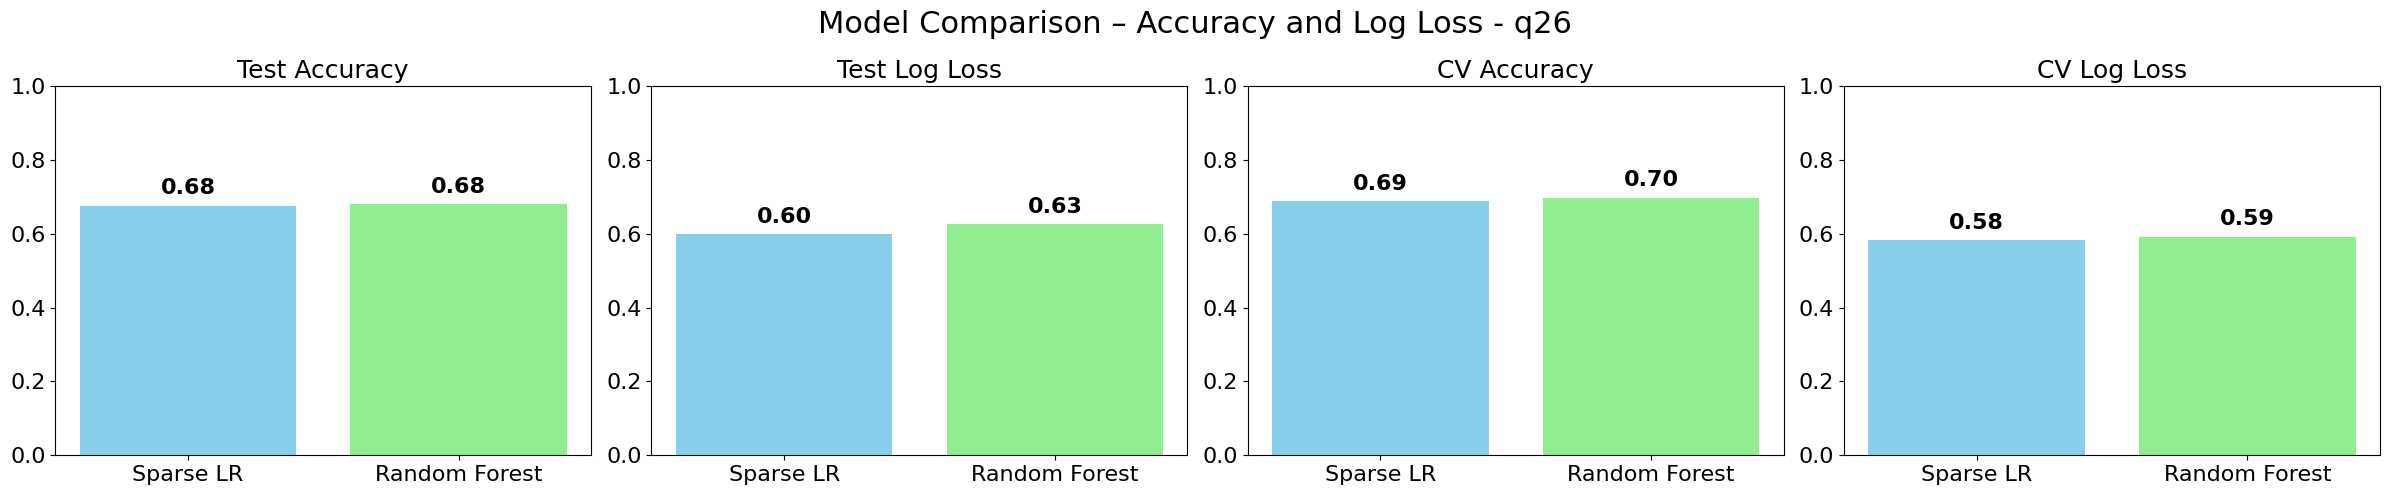

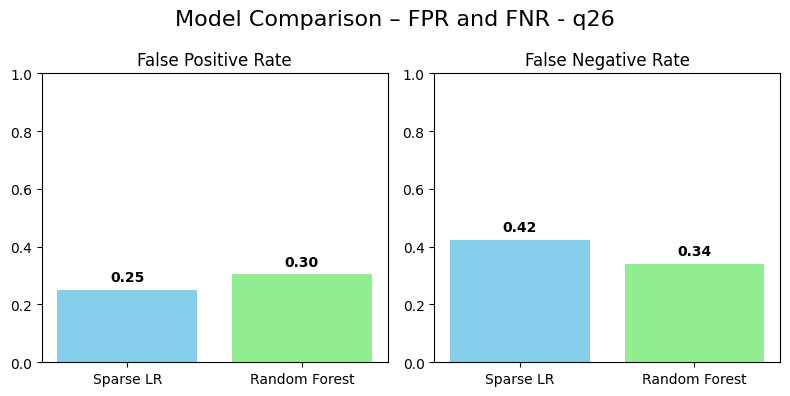

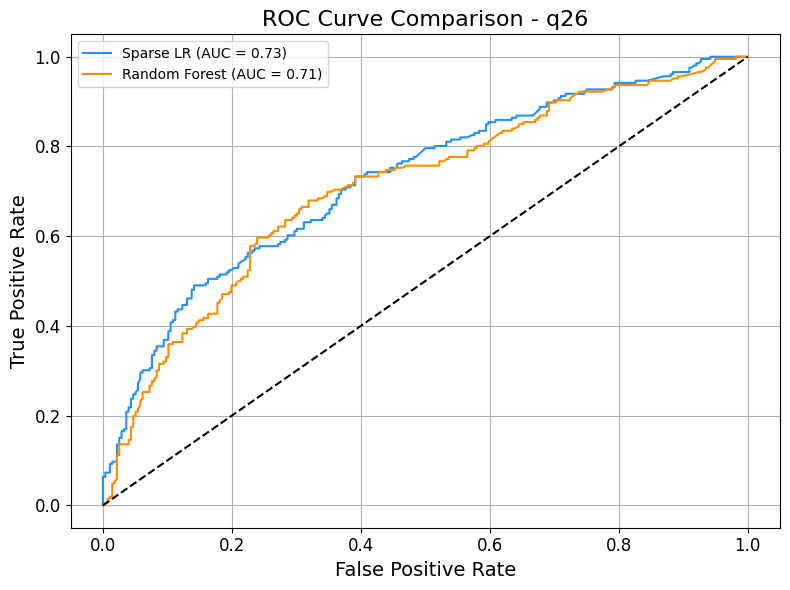

In [54]:
# ------------ 1. Display Shared Top Features with Labels ------------ #
shared_features = set(top_features_slr['Feature']) & set(top10_rf['Feature'])
labeled_shared = [feature_labels.get(f, f) for f in sorted(shared_features)]
print("Shared Top Features (SLR & RF):")
for name in labeled_shared:
    print("→", name)


# ------------ 2. Compare Metrics (4 in first row, 2 in second) ------------ #

# Replace with your computed values
acc_slr = test_accuracy
acc_rf = test_accuracy_rf

logloss_slr = test_logloss
logloss_rf = test_logloss_rf

fpr_slr = fpr
fpr_rf = fpr_rf

fnr_slr = fnr
fnr_rf = fnr_rf

cv_acc_slr = cv_accuracy_scores.mean()
cv_acc_rf = cv_accuracy_rf.mean()

cv_logloss_slr = cv_logloss_scores.mean()
cv_logloss_rf = cv_logloss_rf.mean()

# Grouped measures
metrics = ['Test Accuracy', 'Test Log Loss', 'CV Accuracy', 'CV Log Loss']
slr_values = [acc_slr, logloss_slr, cv_acc_slr, cv_logloss_slr]
rf_values = [acc_rf, logloss_rf, cv_acc_rf, cv_logloss_rf]

# First row - 4 plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for i, ax in enumerate(axes):
    ax.bar(['Sparse LR', 'Random Forest'], [slr_values[i], rf_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics[i], fontsize=18)
    # Tick label font size
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(0, 1)
    for j, val in enumerate([slr_values[i], rf_values[i]]):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=16)
plt.suptitle("Model Comparison – Accuracy and Log Loss - q26", fontsize=22)
plt.tight_layout()
plt.show()

# Second row - 2 plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fpr_vals = [fpr_slr, fpr_rf]
fnr_vals = [fnr_slr, fnr_rf]
labels = ['False Positive Rate', 'False Negative Rate']
for i, ax in enumerate(axes):
    data = fpr_vals if i == 0 else fnr_vals
    ax.bar(['Sparse LR', 'Random Forest'], data, color=['skyblue', 'lightgreen'])
    ax.set_title(labels[i])
    ax.set_ylim(0, 1)
    for j, val in enumerate(data):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
plt.suptitle("Model Comparison – FPR and FNR - q26", fontsize=16)
plt.tight_layout()
plt.show()


# ------------ 3. ROC Curve Comparison ------------ #
fpr_slr_curve, tpr_slr, _ = roc_curve(y26_test, y26_proba)
fpr_rf_curve, tpr_rf, _ = roc_curve(y26_test, y_prob_rf)

auc_slr = auc(fpr_slr_curve, tpr_slr)
auc_rf = auc(fpr_rf_curve, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_slr_curve, tpr_slr, label=f'Sparse LR (AUC = {auc_slr:.2f})', color='dodgerblue')
plt.plot(fpr_rf_curve, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison - q26', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Q27

In [55]:
## hereeeeeeeeeeeeeeeeeeee

df_27 = full_df[full_df['q27'].isin([0, 1])].copy()
df_27['target'] = df_27['q27']

# Step 2: Drop irrelevant columns
X27 = df_27.drop(columns=['q26', 'q27', 'q84', 'q84_binary', 'target', 'state', 'sitename', 'q28'])
y27 = df_27['target']

X27 = X27.select_dtypes(include=[float, int]).dropna()
y27 = y27.loc[X27.index]

# print('types of features in X')
print('x.shape ', X27.shape)
print('y.shape ', y27.shape)

X27_train, X27_test, y27_train, y27_test = train_test_split(
    X27, y27, test_size=0.3, random_state=42, stratify=y27
)

numeric_columns = ['bmipct', 'gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Step 4: Scale features
scaler = StandardScaler()
X27_train[numeric_columns] = scaler.fit_transform(X27_train[numeric_columns])
X27_test[numeric_columns] = scaler.transform(X27_test[numeric_columns])


x.shape  (1604, 13)
y.shape  (1604,)


## Sparse Logistic Regression

/tmp/ipython-input-56-3720076226.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')


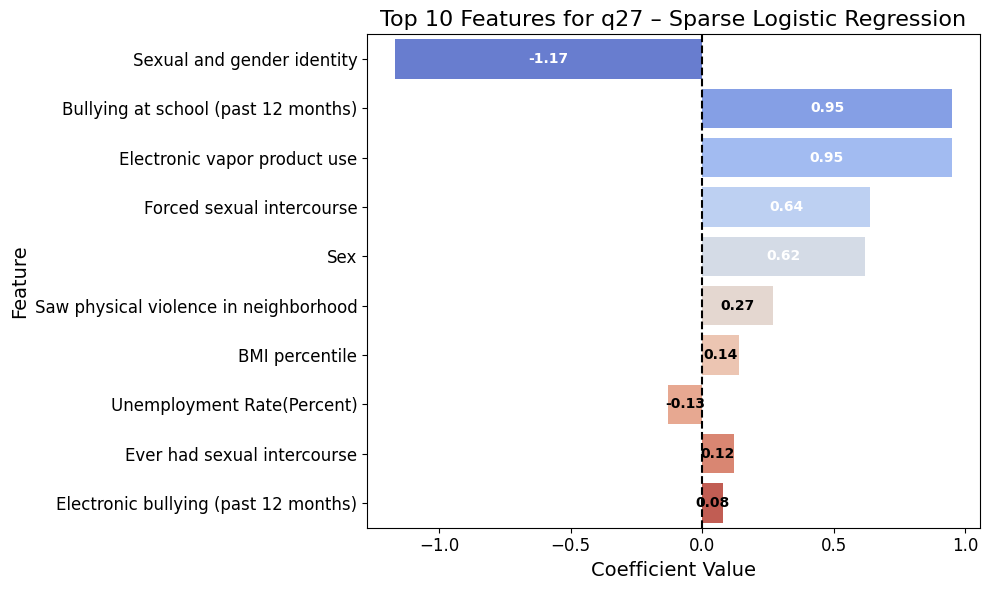

Cross-Validation (20-fold):
Accuracy: 0.8512 ± 0.0066
Log Loss: 0.3687 ± 0.0110

Test Set Performance:
Accuracy: 0.8527
Log Loss: 0.3874

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           394            8
Actual 1 (Yes Sadness)           63           17

False Positive Rate (FPR): 0.0199
False Negative Rate (FNR): 0.7875

Top 5 Individual Test Cases with Highest Log Loss (Potential Misclassifications):
       true_label  predicted  pred_proba  log_loss
4462          1.0        0.0    0.031947  3.443678
4627          1.0        0.0    0.034173  3.376324
4386          1.0        0.0    0.036899  3.299568
4435          1.0        0.0    0.036899  3.299568
12515         1.0        0.0    0.043739  3.129512


In [56]:
# Step 6: Train final model on train set (used for interpretation only!)
model_slr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
model_slr.fit(X27_train, y27_train)

# Store feature names and coefficients before any overwriting
final_coef_slr = model_slr.coef_[0]
final_features_slr = X27.columns

# Step 12: Top 10 features (based on model trained before CV)
coef_df_slr = pd.DataFrame({
    'Feature': final_features_slr,
    'Coefficient': final_coef_slr
})
non_zero_slr = coef_df_slr[coef_df_slr['Coefficient'] != 0]
top_features_slr = non_zero_slr.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
top_features_slr['Label'] = top_features_slr['Feature'].map(feature_labels).fillna(top_features_slr['Feature'])

# Step 13: Plot top features
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')
for i, (value, name) in enumerate(zip(top_features_slr['Coefficient'], top_features_slr['Label'])):
    ax.text(value / 2, i, f"{value:.2f}",
            color='white' if abs(value) > 0.4 else 'black',
            ha='center', va='center', fontweight='bold')

plt.title('Top 10 Features for q27 – Sparse Logistic Regression', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# ------------------ Evaluation Metrics ------------------ #

# --- 1. Cross-Validation Accuracy and Log Loss with CI --- #
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

cv_accuracy_scores = cross_val_score(model_slr, X27_train, y27_train, cv=cv, scoring='accuracy')
cv_logloss_scores = cross_val_score(model_slr, X27_train, y27_train, cv=cv, scoring='neg_log_loss')

# Convert log loss scores to positive
cv_logloss_scores = -cv_logloss_scores

# 95% Confidence Intervals
acc_ci = st.t.interval(0.95, len(cv_accuracy_scores)-1, loc=np.mean(cv_accuracy_scores), scale=st.sem(cv_accuracy_scores))
logloss_ci = st.t.interval(0.95, len(cv_logloss_scores)-1, loc=np.mean(cv_logloss_scores), scale=st.sem(cv_logloss_scores))

print("Cross-Validation (20-fold):")
print(f"Accuracy: {np.mean(cv_accuracy_scores):.4f} ± {st.sem(cv_accuracy_scores):.4f}")
print(f"Log Loss: {np.mean(cv_logloss_scores):.4f} ± {st.sem(cv_logloss_scores):.4f}")

# --- 2. Test Accuracy and Log Loss --- #
y27_pred = model_slr.predict(X27_test)
y27_proba = model_slr.predict_proba(X27_test)[:, 1]

test_accuracy = accuracy_score(y27_test, y27_pred)
test_logloss = log_loss(y27_test, y27_proba)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Log Loss: {test_logloss:.4f}")

# --- 3. Confusion Matrix + FPR, FNR --- #
# Compute confusion matrix
conf_matrix = confusion_matrix(y27_test, y27_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Format into DataFrame
conf_df = pd.DataFrame(
    conf_matrix,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

# Print results
print("\nConfusion Matrix:")
print(conf_df)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")


# Compute individual log losses
eps = 1e-15  # for numerical stability
y_probs = np.clip(y27_proba, eps, 1 - eps)
log_losses = -(y27_test * np.log(y_probs) + (1 - y27_test) * np.log(1 - y_probs))

# Convert to DataFrame for inspection
results_df = X27_test.copy()
results_df['true_label'] = y27_test
results_df['pred_proba'] = y27_proba
results_df['predicted'] = model_slr.predict(X27_test)
results_df['log_loss'] = log_losses

# Sort by highest log loss
worst_cases = results_df.sort_values(by='log_loss', ascending=False).head(5)

# Display
print("\nTop 5 Individual Test Cases with Highest Log Loss (Potential Misclassifications):")
print(worst_cases[['true_label', 'predicted', 'pred_proba', 'log_loss']])




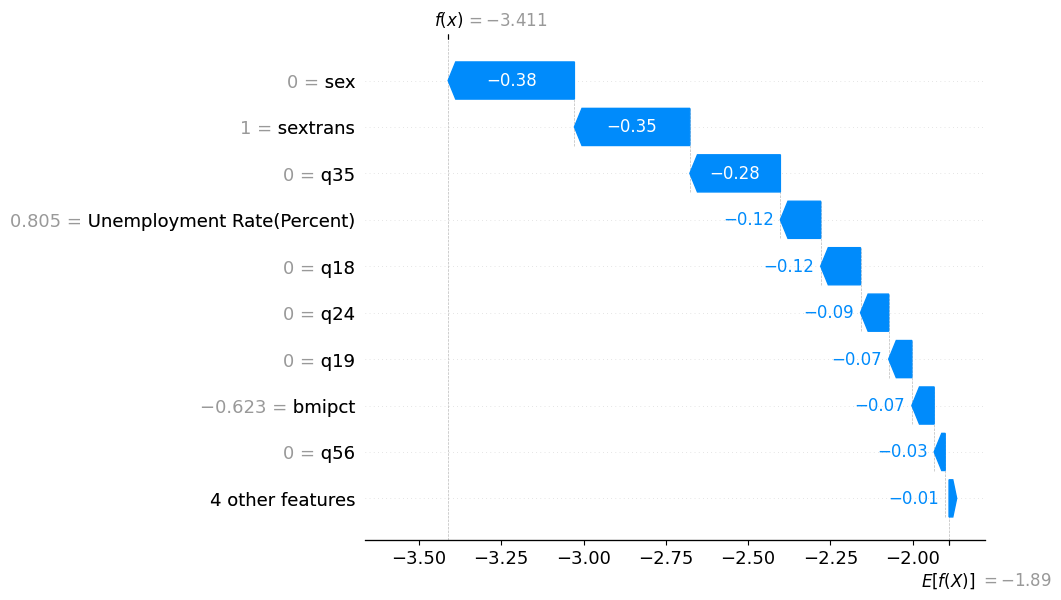

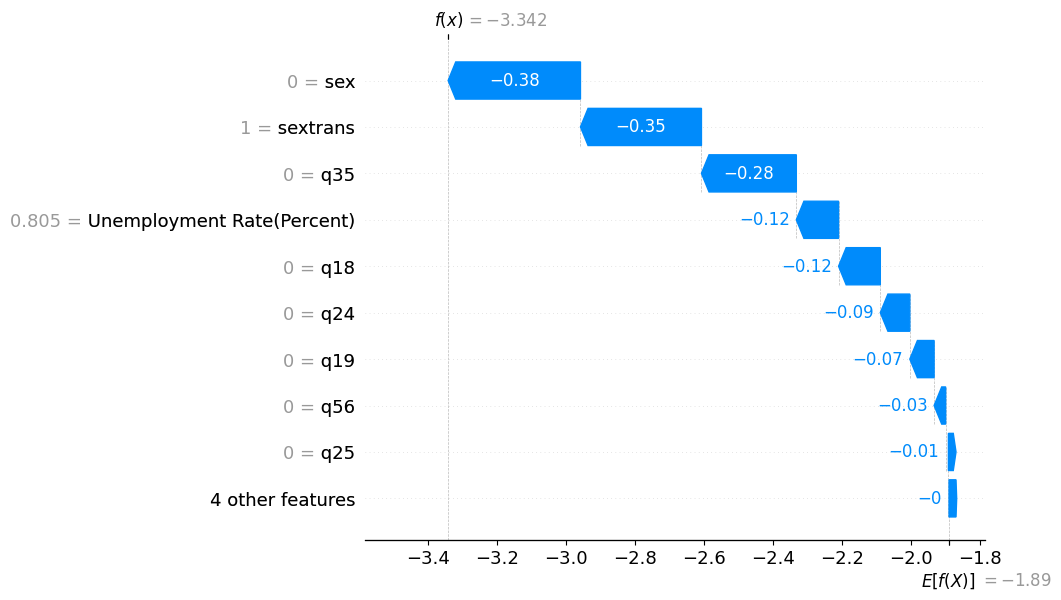

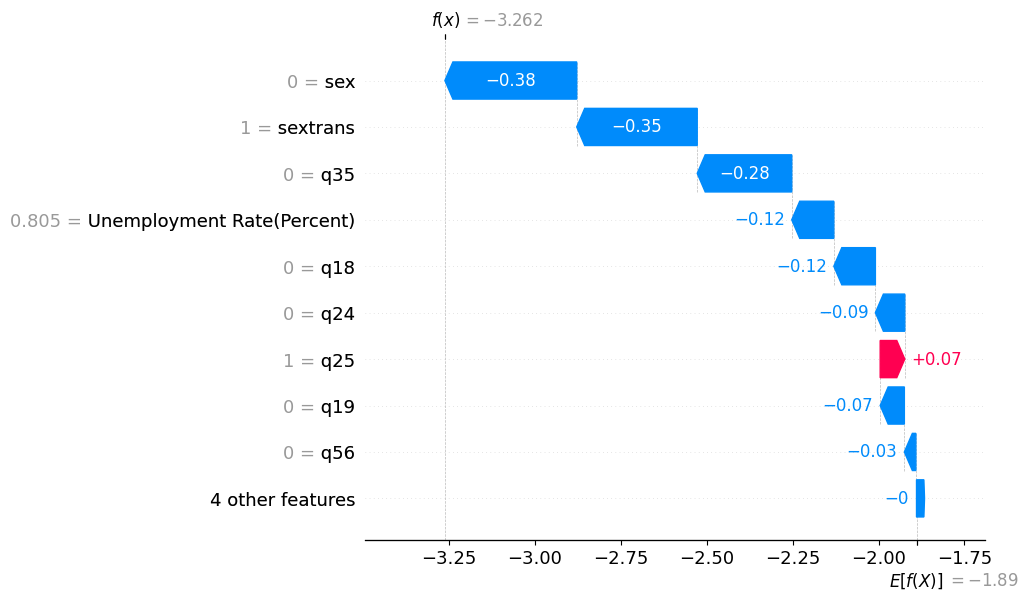

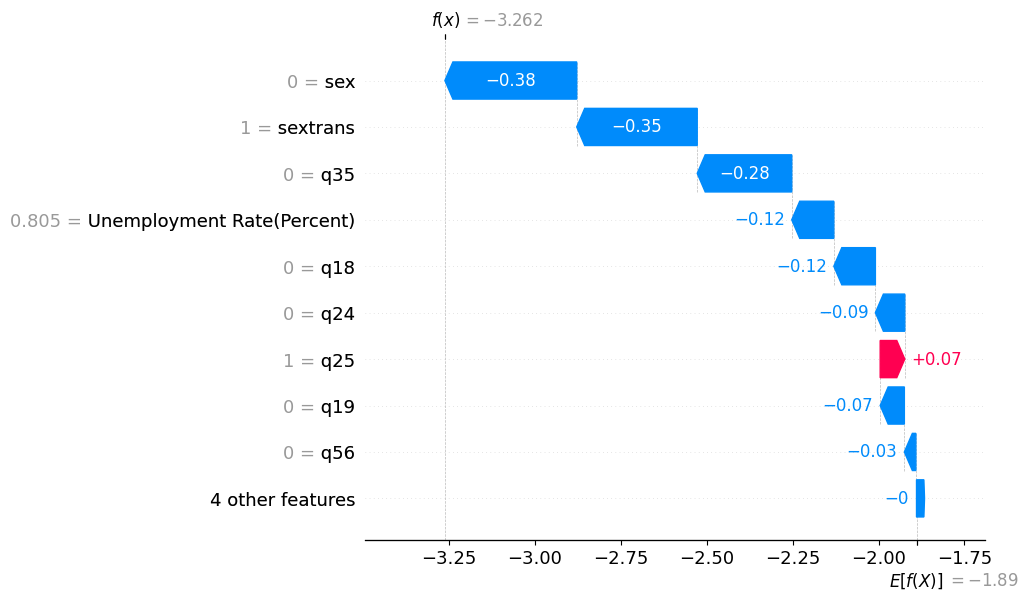

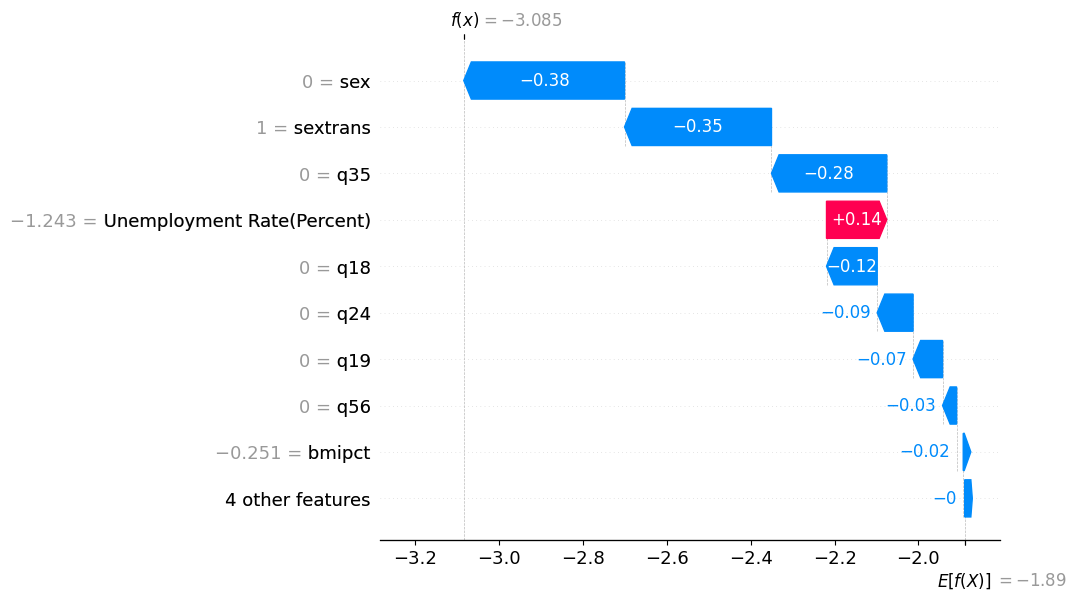

In [57]:
# Sample the background from training set (to approximate expected values)
background = shap.maskers.Independent(X27_train, max_samples=100)

# Use SHAP’s linear explainer (works with LogisticRegression and doesn't require GPU)
explainer = shap.Explainer(model_slr, background)

# Get the SHAP values for the top 5 high-error test examples
X_top5 = X27_test.loc[[4462, 4627, 4386, 4435, 12515]]
shap_values_top5 = explainer(X_top5)

# Visualize SHAP values for each sample
for i in range(len(shap_values_top5)):
    shap.plots.waterfall(shap_values_top5[i], max_display=10)


## Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest with RandomizedSearchCV
Best Parameters: {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


/tmp/ipython-input-58-713117825.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')
/tmp/ipython-input-58-713117825.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')


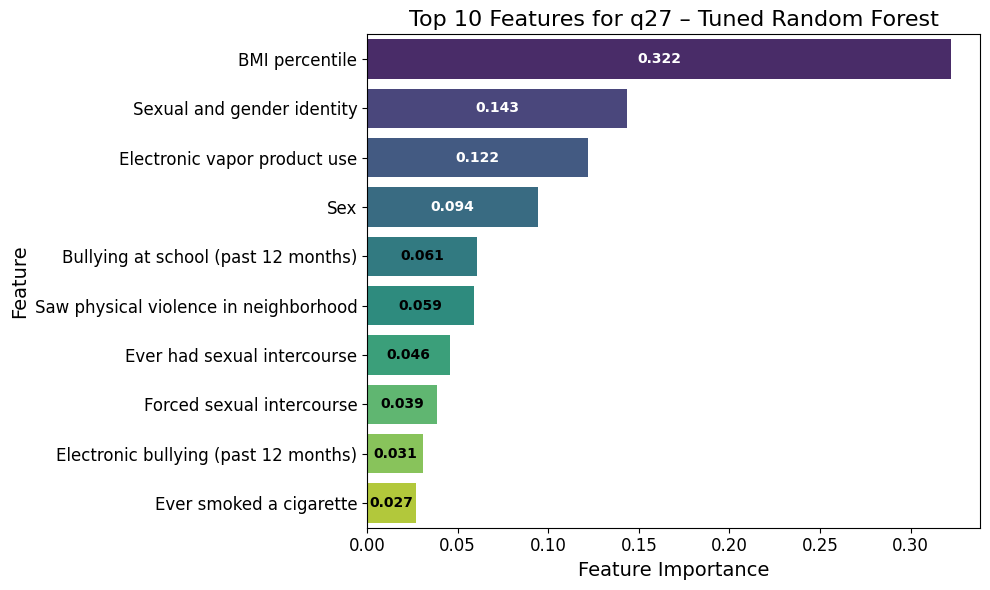


Cross-Validation (20-fold):
Accuracy: 0.7905 ± 0.0586
Log Loss: 0.4635 ± 0.0656

Test Set Performance:
Accuracy: 0.7884
Log Loss: 0.4679

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           351           51
Actual 1 (Yes Sadness)           51           29

False Positive Rate (FPR): 0.1269
False Negative Rate (FNR): 0.6375


In [58]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(5, 25),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(2, 11),
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search (20 iterations, 5-fold CV)
rf_search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit search on training data
rf_search.fit(X27_train, y27_train)

# Best estimator
best_rf = rf_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X27_test)
y_prob_rf = best_rf.predict_proba(X27_test)[:, 1]

print("\n Random Forest with RandomizedSearchCV")
print("Best Parameters:", rf_search.best_params_)

# Top 10 important features
importances_rf = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X27.columns,
    'Importance': importances_rf
})
top10_rf = rf_importance_df.sort_values(by='Importance', ascending=False).head(10)
top10_rf['Label'] = top10_rf['Feature'].map(feature_labels).fillna(top10_rf['Feature'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')

for i, (imp, label) in enumerate(zip(top10_rf['Importance'], top10_rf['Label'])):
    ax.text(imp / 2, i, f"{imp:.3f}",
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color='white' if imp > 0.08 else 'black')
sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')
plt.title("Top 10 Features for q27 – Tuned Random Forest", fontsize=16)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -------------------- Cross-Validation Performance (20-fold) -------------------- #
cv_accuracy_rf = cross_val_score(best_rf, X27_train, y27_train, cv=20, scoring='accuracy')
cv_logloss_rf = -cross_val_score(best_rf, X27_train, y27_train, cv=20, scoring='neg_log_loss')

print("\nCross-Validation (20-fold):")
print(f"Accuracy: {cv_accuracy_rf.mean():.4f} ± {cv_accuracy_rf.std():.4f}")
print(f"Log Loss: {cv_logloss_rf.mean():.4f} ± {cv_logloss_rf.std():.4f}")

# -------------------- Test Set Performance -------------------- #
test_accuracy_rf = accuracy_score(y27_test, y_pred_rf)
test_logloss_rf = log_loss(y27_test, y_prob_rf)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Log Loss: {test_logloss_rf:.4f}")

# -------------------- Confusion Matrix + FPR, FNR -------------------- #
conf_matrix_rf = confusion_matrix(y27_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

fpr_rf = fp_rf / (fp_rf + tn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)

conf_df_rf = pd.DataFrame(
    conf_matrix_rf,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

print("\nConfusion Matrix:")
print(conf_df_rf)
print(f"\nFalse Positive Rate (FPR): {fpr_rf:.4f}")
print(f"False Negative Rate (FNR): {fnr_rf:.4f}")


## Model Comparsion

Shared Top Features (SLR & RF):
→ BMI percentile
→ Saw physical violence in neighborhood
→ Forced sexual intercourse
→ Bullying at school (past 12 months)
→ Electronic bullying (past 12 months)
→ Electronic vapor product use
→ Ever had sexual intercourse
→ Sex
→ Sexual and gender identity


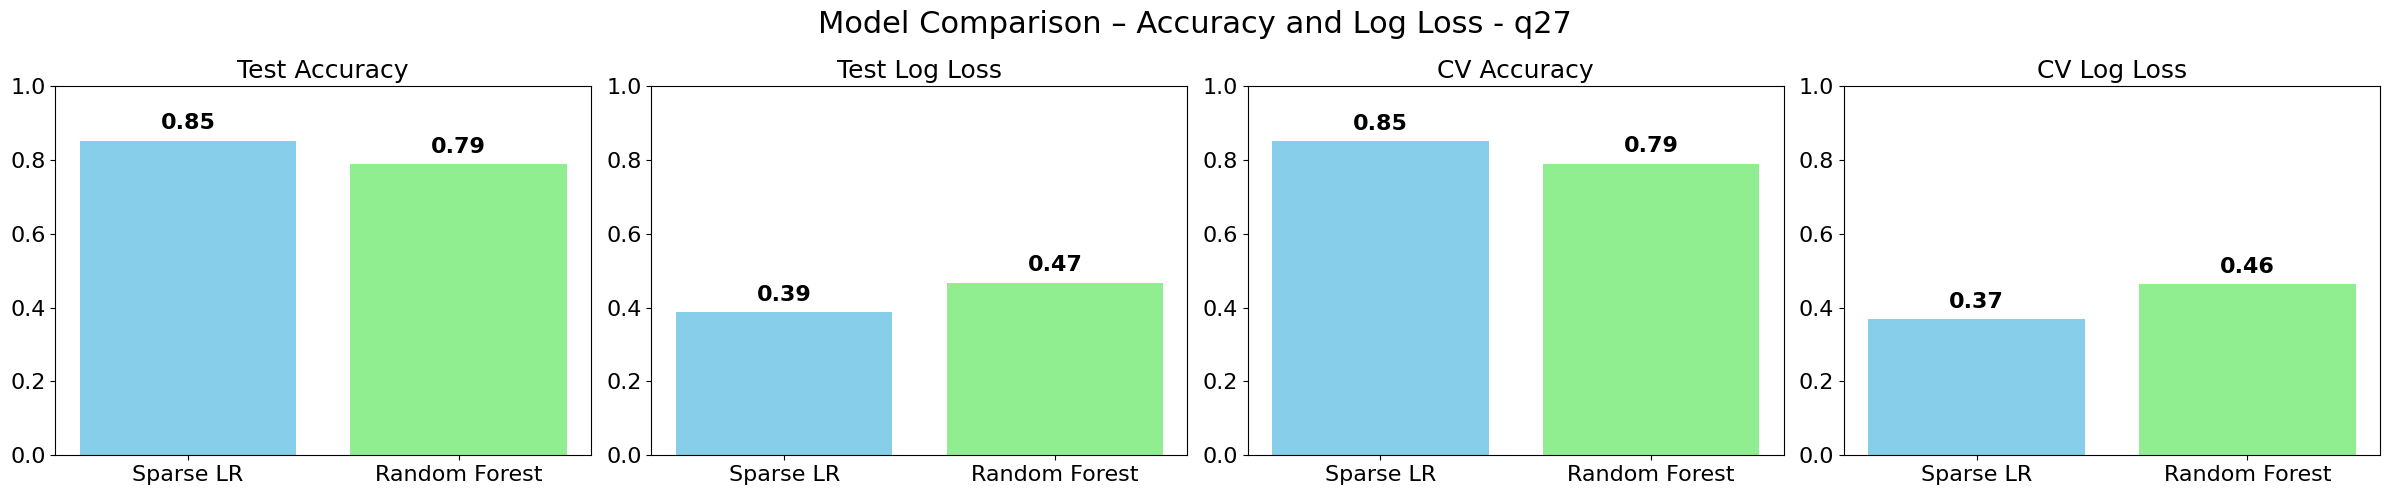

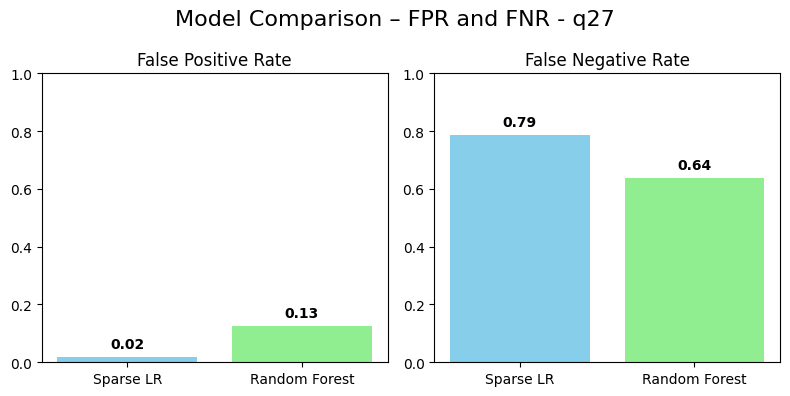

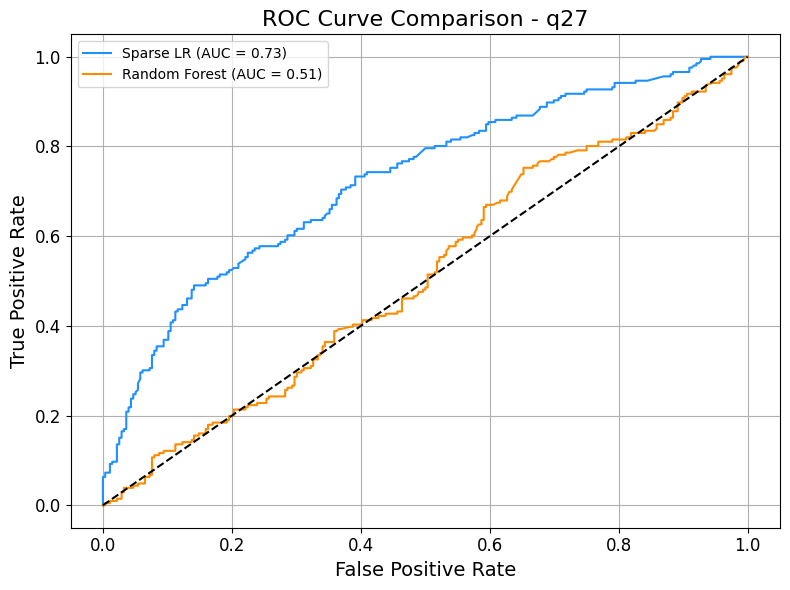

In [59]:
# ------------ 1. Display Shared Top Features with Labels ------------ #
shared_features = set(top_features_slr['Feature']) & set(top10_rf['Feature'])
labeled_shared = [feature_labels.get(f, f) for f in sorted(shared_features)]
print("Shared Top Features (SLR & RF):")
for name in labeled_shared:
    print("→", name)


# ------------ 2. Compare Metrics (4 in first row, 2 in second) ------------ #

# Replace with your computed values
acc_slr = test_accuracy
acc_rf = test_accuracy_rf

logloss_slr = test_logloss
logloss_rf = test_logloss_rf

fpr_slr = fpr
fpr_rf = fpr_rf

fnr_slr = fnr
fnr_rf = fnr_rf

cv_acc_slr = cv_accuracy_scores.mean()
cv_acc_rf = cv_accuracy_rf.mean()

cv_logloss_slr = cv_logloss_scores.mean()
cv_logloss_rf = cv_logloss_rf.mean()

# Grouped measures
metrics = ['Test Accuracy', 'Test Log Loss', 'CV Accuracy', 'CV Log Loss']
slr_values = [acc_slr, logloss_slr, cv_acc_slr, cv_logloss_slr]
rf_values = [acc_rf, logloss_rf, cv_acc_rf, cv_logloss_rf]

# First row - 4 plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for i, ax in enumerate(axes):
    ax.bar(['Sparse LR', 'Random Forest'], [slr_values[i], rf_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics[i], fontsize=18)
    # Tick label font size
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(0, 1)
    for j, val in enumerate([slr_values[i], rf_values[i]]):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=16)
plt.suptitle("Model Comparison – Accuracy and Log Loss - q27", fontsize=22)
plt.tight_layout()
plt.show()

# Second row - 2 plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fpr_vals = [fpr_slr, fpr_rf]
fnr_vals = [fnr_slr, fnr_rf]
labels = ['False Positive Rate', 'False Negative Rate']
for i, ax in enumerate(axes):
    data = fpr_vals if i == 0 else fnr_vals
    ax.bar(['Sparse LR', 'Random Forest'], data, color=['skyblue', 'lightgreen'])
    ax.set_title(labels[i])
    ax.set_ylim(0, 1)
    for j, val in enumerate(data):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
plt.suptitle("Model Comparison – FPR and FNR - q27", fontsize=16)
plt.tight_layout()
plt.show()


# ------------ 3. ROC Curve Comparison ------------ #
fpr_slr_curve, tpr_slr, _ = roc_curve(y26_test, y26_proba)
fpr_rf_curve, tpr_rf, _ = roc_curve(y26_test, y_prob_rf)

auc_slr = auc(fpr_slr_curve, tpr_slr)
auc_rf = auc(fpr_rf_curve, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_slr_curve, tpr_slr, label=f'Sparse LR (AUC = {auc_slr:.2f})', color='dodgerblue')
plt.plot(fpr_rf_curve, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison - q27', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Q84

In [60]:
## hereeeeeeeeeeeeeeeeeeee

df_84 = full_df[full_df['q84_binary'].isin([0, 1])].copy()
df_84['target'] = df_84['q84_binary']

# Step 2: Drop irrelevant columns
X84 = df_84.drop(columns=['q26', 'q27', 'q84', 'q84_binary', 'target', 'state', 'sitename', 'q28'])
y84 = df_84['target']

X84 = X84.select_dtypes(include=[float, int]).dropna()
y84 = y84.loc[X84.index]

# print('types of features in X')
print('x.shape ', X84.shape)
print('y.shape ', y84.shape)

X84_train, X84_test, y84_train, y84_test = train_test_split(
    X84, y84, test_size=0.3, random_state=42, stratify=y84
)

numeric_columns = ['bmipct', 'gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Step 4: Scale features
scaler = StandardScaler()
X84_train[numeric_columns] = scaler.fit_transform(X84_train[numeric_columns])
X84_test[numeric_columns] = scaler.transform(X84_test[numeric_columns])


x.shape  (1604, 13)
y.shape  (1604,)


## Sparse Logistic Regression

/tmp/ipython-input-61-2890422520.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')


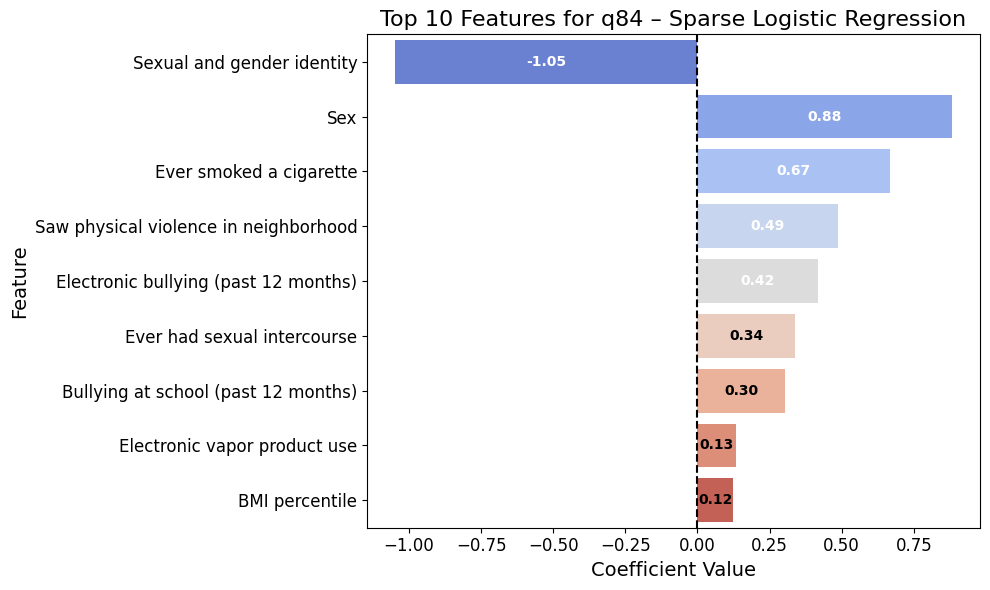

Cross-Validation (20-fold):
Accuracy: 0.7655 ± 0.0063
Log Loss: 0.5131 ± 0.0105

Test Set Performance:
Accuracy: 0.7241
Log Loss: 0.5577

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           312           39
Actual 1 (Yes Sadness)           94           37

False Positive Rate (FPR): 0.1111
False Negative Rate (FNR): 0.7176


In [61]:
# Step 6: Train final model on train set (used for interpretation only!)
model_slr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
model_slr.fit(X84_train, y84_train)

# Store feature names and coefficients before any overwriting
final_coef_slr = model_slr.coef_[0]
final_features_slr = X84.columns

# Step 12: Top 10 features (based on model trained before CV)
coef_df_slr = pd.DataFrame({
    'Feature': final_features_slr,
    'Coefficient': final_coef_slr
})
non_zero_slr = coef_df_slr[coef_df_slr['Coefficient'] != 0]
top_features_slr = non_zero_slr.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
top_features_slr['Label'] = top_features_slr['Feature'].map(feature_labels).fillna(top_features_slr['Feature'])

# Step 13: Plot top features
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')
for i, (value, name) in enumerate(zip(top_features_slr['Coefficient'], top_features_slr['Label'])):
    ax.text(value / 2, i, f"{value:.2f}",
            color='white' if abs(value) > 0.4 else 'black',
            ha='center', va='center', fontweight='bold')

plt.title('Top 10 Features for q84 – Sparse Logistic Regression', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# ------------------ Evaluation Metrics ------------------ #

# --- 1. Cross-Validation Accuracy and Log Loss with CI --- #
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

cv_accuracy_scores = cross_val_score(model_slr, X84_train, y84_train, cv=cv, scoring='accuracy')
cv_logloss_scores = cross_val_score(model_slr, X84_train, y84_train, cv=cv, scoring='neg_log_loss')

# Convert log loss scores to positive
cv_logloss_scores = -cv_logloss_scores

# 95% Confidence Intervals
acc_ci = st.t.interval(0.95, len(cv_accuracy_scores)-1, loc=np.mean(cv_accuracy_scores), scale=st.sem(cv_accuracy_scores))
logloss_ci = st.t.interval(0.95, len(cv_logloss_scores)-1, loc=np.mean(cv_logloss_scores), scale=st.sem(cv_logloss_scores))

print("Cross-Validation (20-fold):")
print(f"Accuracy: {np.mean(cv_accuracy_scores):.4f} ± {st.sem(cv_accuracy_scores):.4f}")
print(f"Log Loss: {np.mean(cv_logloss_scores):.4f} ± {st.sem(cv_logloss_scores):.4f}")

# --- 2. Test Accuracy and Log Loss --- #
y84_pred = model_slr.predict(X84_test)
y84_proba = model_slr.predict_proba(X84_test)[:, 1]

test_accuracy = accuracy_score(y84_test, y84_pred)
test_logloss = log_loss(y84_test, y84_proba)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Log Loss: {test_logloss:.4f}")

# --- 3. Confusion Matrix + FPR, FNR --- #
# Compute confusion matrix
conf_matrix = confusion_matrix(y84_test, y84_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Format into DataFrame
conf_df = pd.DataFrame(
    conf_matrix,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

# Print results
print("\nConfusion Matrix:")
print(conf_df)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")



## Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest with RandomizedSearchCV
Best Parameters: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 6}


/tmp/ipython-input-62-912631328.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')
/tmp/ipython-input-62-912631328.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')


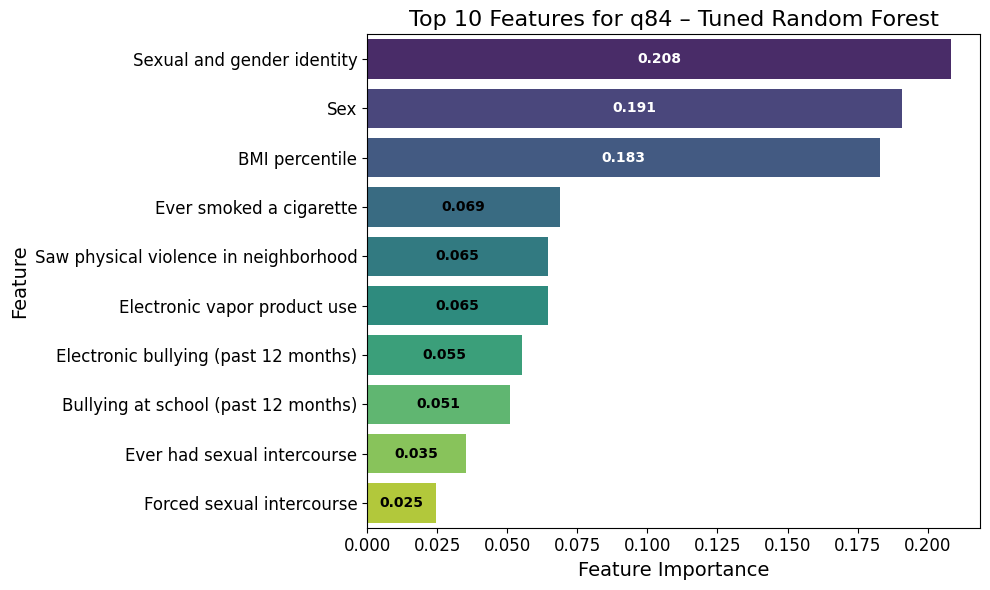


Cross-Validation (20-fold):
Accuracy: 0.6997 ± 0.0505
Log Loss: 0.5906 ± 0.0352

Test Set Performance:
Accuracy: 0.6390
Log Loss: 0.6378

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           236          115
Actual 1 (Yes Sadness)           59           72

False Positive Rate (FPR): 0.3276
False Negative Rate (FNR): 0.4504


In [62]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(5, 25),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(2, 11),
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search (20 iterations, 5-fold CV)
rf_search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit search on training data
rf_search.fit(X84_train, y84_train)

# Best estimator
best_rf = rf_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X84_test)
y_prob_rf = best_rf.predict_proba(X84_test)[:, 1]

print("\n Random Forest with RandomizedSearchCV")
print("Best Parameters:", rf_search.best_params_)

# Top 10 important features
importances_rf = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X84.columns,
    'Importance': importances_rf
})
top10_rf = rf_importance_df.sort_values(by='Importance', ascending=False).head(10)
top10_rf['Label'] = top10_rf['Feature'].map(feature_labels).fillna(top10_rf['Feature'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')

for i, (imp, label) in enumerate(zip(top10_rf['Importance'], top10_rf['Label'])):
    ax.text(imp / 2, i, f"{imp:.3f}",
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color='white' if imp > 0.08 else 'black')
sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')
plt.title("Top 10 Features for q84 – Tuned Random Forest", fontsize=16)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -------------------- Cross-Validation Performance (20-fold) -------------------- #
cv_accuracy_rf = cross_val_score(best_rf, X84_train, y84_train, cv=20, scoring='accuracy')
cv_logloss_rf = -cross_val_score(best_rf, X84_train, y84_train, cv=20, scoring='neg_log_loss')

print("\nCross-Validation (20-fold):")
print(f"Accuracy: {cv_accuracy_rf.mean():.4f} ± {cv_accuracy_rf.std():.4f}")
print(f"Log Loss: {cv_logloss_rf.mean():.4f} ± {cv_logloss_rf.std():.4f}")

# -------------------- Test Set Performance -------------------- #
test_accuracy_rf = accuracy_score(y84_test, y_pred_rf)
test_logloss_rf = log_loss(y84_test, y_prob_rf)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Log Loss: {test_logloss_rf:.4f}")

# -------------------- Confusion Matrix + FPR, FNR -------------------- #
conf_matrix_rf = confusion_matrix(y84_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

fpr_rf = fp_rf / (fp_rf + tn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)

conf_df_rf = pd.DataFrame(
    conf_matrix_rf,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

print("\nConfusion Matrix:")
print(conf_df_rf)
print(f"\nFalse Positive Rate (FPR): {fpr_rf:.4f}")
print(f"False Negative Rate (FNR): {fnr_rf:.4f}")


## Model Comparsion

Shared Top Features (SLR & RF):
→ BMI percentile
→ Saw physical violence in neighborhood
→ Bullying at school (past 12 months)
→ Electronic bullying (past 12 months)
→ Ever smoked a cigarette
→ Electronic vapor product use
→ Ever had sexual intercourse
→ Sex
→ Sexual and gender identity


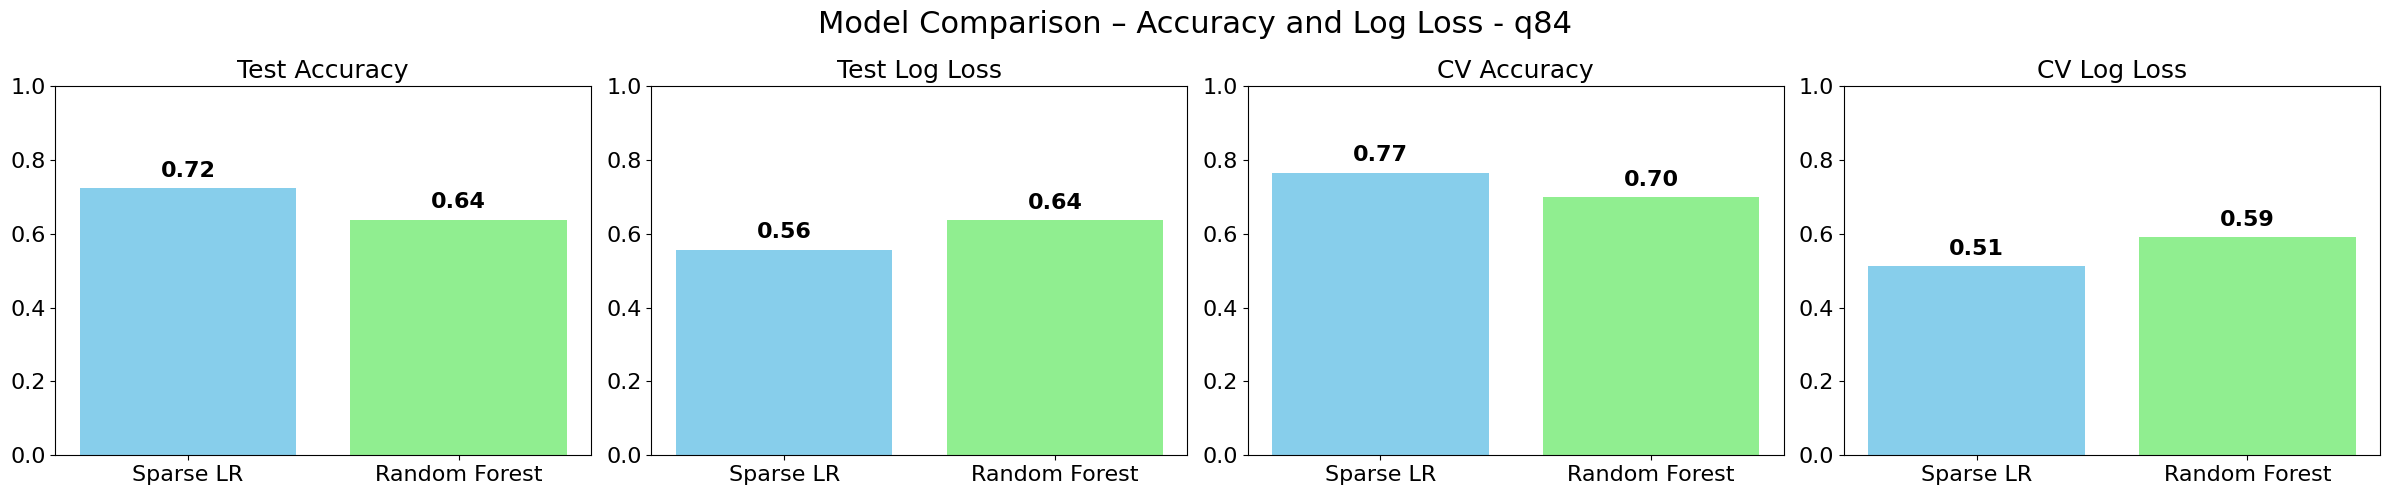

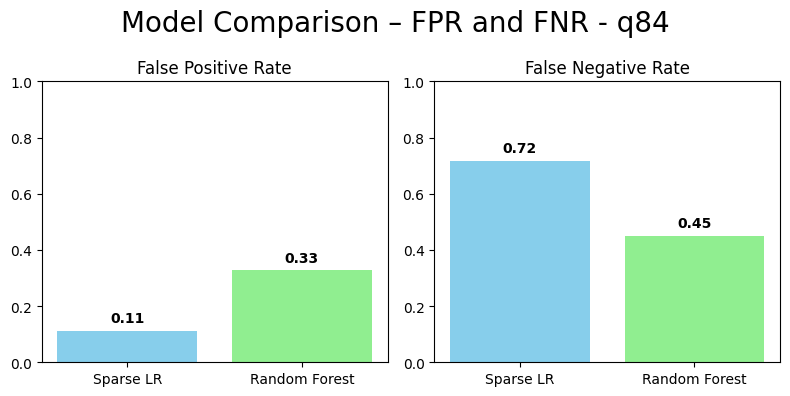

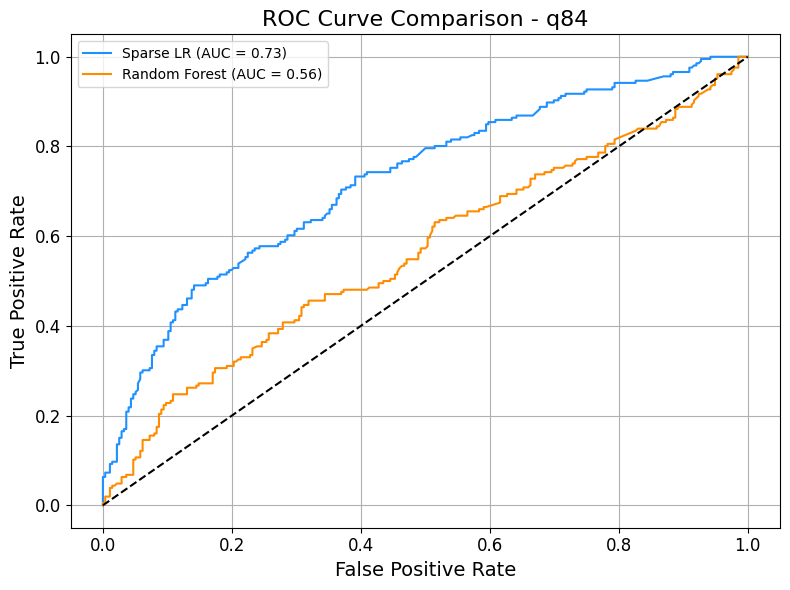

In [63]:
# ------------ 1. Display Shared Top Features with Labels ------------ #
shared_features = set(top_features_slr['Feature']) & set(top10_rf['Feature'])
labeled_shared = [feature_labels.get(f, f) for f in sorted(shared_features)]
print("Shared Top Features (SLR & RF):")
for name in labeled_shared:
    print("→", name)


# ------------ 2. Compare Metrics (4 in first row, 2 in second) ------------ #

# Replace with your computed values
acc_slr = test_accuracy
acc_rf = test_accuracy_rf

logloss_slr = test_logloss
logloss_rf = test_logloss_rf

fpr_slr = fpr
fpr_rf = fpr_rf

fnr_slr = fnr
fnr_rf = fnr_rf

cv_acc_slr = cv_accuracy_scores.mean()
cv_acc_rf = cv_accuracy_rf.mean()

cv_logloss_slr = cv_logloss_scores.mean()
cv_logloss_rf = cv_logloss_rf.mean()

# Grouped measures
metrics = ['Test Accuracy', 'Test Log Loss', 'CV Accuracy', 'CV Log Loss']
slr_values = [acc_slr, logloss_slr, cv_acc_slr, cv_logloss_slr]
rf_values = [acc_rf, logloss_rf, cv_acc_rf, cv_logloss_rf]

# First row - 4 plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for i, ax in enumerate(axes):
    ax.bar(['Sparse LR', 'Random Forest'], [slr_values[i], rf_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics[i], fontsize=18)
    # Tick label font size
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(0, 1)
    for j, val in enumerate([slr_values[i], rf_values[i]]):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=16)
plt.suptitle("Model Comparison – Accuracy and Log Loss - q84", fontsize=22)
plt.tight_layout()
plt.show()

# Second row - 2 plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fpr_vals = [fpr_slr, fpr_rf]
fnr_vals = [fnr_slr, fnr_rf]
labels = ['False Positive Rate', 'False Negative Rate']
for i, ax in enumerate(axes):
    data = fpr_vals if i == 0 else fnr_vals
    ax.bar(['Sparse LR', 'Random Forest'], data, color=['skyblue', 'lightgreen'])
    ax.set_title(labels[i])
    ax.set_ylim(0, 1)
    for j, val in enumerate(data):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
plt.suptitle("Model Comparison – FPR and FNR - q84", fontsize=20)
plt.tight_layout()
plt.show()


# ------------ 3. ROC Curve Comparison ------------ #
fpr_slr_curve, tpr_slr, _ = roc_curve(y26_test, y26_proba)
fpr_rf_curve, tpr_rf, _ = roc_curve(y26_test, y_prob_rf)

auc_slr = auc(fpr_slr_curve, tpr_slr)
auc_rf = auc(fpr_rf_curve, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_slr_curve, tpr_slr, label=f'Sparse LR (AUC = {auc_slr:.2f})', color='dodgerblue')
plt.plot(fpr_rf_curve, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison - q84', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCC

In [64]:
# ------------------ 1. Data Preparation ------------------ #
df_pcc = full_df[
    full_df['q26'].isin([0, 1]) &
    full_df['q27'].isin([0, 1]) &
    full_df['q84_binary'].isin([0, 1])
].copy()

X_pcc = df_pcc.drop(columns=['q26', 'q27', 'q84', 'q84_binary', 'state', 'sitename', 'q28'])
Y_pcc = df_pcc[['q26', 'q27', 'q84_binary']]

X_pcc = X_pcc.select_dtypes(include=[float, int]).dropna()
Y_pcc = Y_pcc.loc[X_pcc.index]

X_train_pcc, X_test_pcc, Y_train_pcc, Y_test_pcc = train_test_split(
    X_pcc, Y_pcc, test_size=0.3, random_state=42, stratify=Y_pcc['q26']
)

scaler = StandardScaler()
X_train_pcc[['bmipct']] = scaler.fit_transform(X_train_pcc[['bmipct']])
X_test_pcc[['bmipct']] = scaler.transform(X_test_pcc[['bmipct']])

# ------------------ 2. PCC Class ------------------ #
class ProbabilisticClassifierChain:
    def __init__(self, baselearner):
        self.baselearner = baselearner
        self.r_ = None
        self.fitted_ = None
        self.patterns_ = None

    def fit(self, x, y):
        x, y = check_X_y(x, y, multi_output=True)
        _, r = y.shape
        self.r_ = r
        self.fitted_ = []
        self.patterns_ = [list(p) for p in product(*(r * [range(2)]))]
        for i in range(r):
            _x = np.column_stack([x, y[:, :i]]) if i > 0 else x
            _y = y[:, i]
            model = clone(self.baselearner, safe=False)
            model.fit(_x, _y)
            self.fitted_.append(model)
        return self

    def predict_proba_of(self, x, y):
        _x = x.copy()
        if len(y.shape) == 1:
            y = y.reshape(1, self.r_)
        idx = np.arange(len(x))
        res = self.fitted_[0].predict_proba(_x)[idx, y[:, 0]]
        for i in range(1, self.r_):
            _x = np.column_stack([_x, np.ones(len(x)) * y[:, i - 1]])
            res *= self.fitted_[i].predict_proba(_x)[idx, y[:, i]]
        return res

    def predict(self, x):
        x = check_array(x)
        pattern_matrix = np.array([self.predict_proba_of(x, np.array(p)) for p in self.patterns_]).T
        max_indices = np.argmax(pattern_matrix, axis=1)
        return np.array([self.patterns_[i] for i in max_indices])

# ------------------ 3. Train ------------------ #
pcc_model = ProbabilisticClassifierChain(LogisticRegression(solver='liblinear', max_iter=1000))
pcc_model.fit(X_train_pcc.to_numpy(), Y_train_pcc.to_numpy())

# ------------------ 4. Extract Top Features ------------------ #

top_features_per_target = []

# Loop through each fitted model and collect top features
for i, clf in enumerate(pcc_model.fitted_):
    coefs = clf.coef_.ravel()
    valid_indices = np.arange(len(coefs))
    abs_coefs = np.abs(coefs)

    # Sort and select top indices safely
    top_indices = valid_indices[np.argsort(abs_coefs)[::-1][:min(10, len(coefs))]]

    # Get column names for top features
    top_feats = [X_train_pcc.columns[i] for i in top_indices if i < X_train_pcc.shape[1]]
    top_features_per_target.extend(top_feats)

# Count frequency of each feature
top_counts = Counter(top_features_per_target)

# Show 10 most common features across all 3 sub-models
print("\nTop 10 Most Frequent Features Across PCC Sub-models:")
for feat, count in top_counts.most_common(10):
    label = feature_labels.get(feat, feat)
    print(f"- {label} (appeared in {count}/3 models)")


# ------------------ 5. Evaluation Metrics ------------------ #

# Predict
Y_pred = pcc_model.predict(X_test_pcc.to_numpy())
Y_true = Y_test_pcc.to_numpy()

# (a) Accuracy per target
print("\n(a) Accuracy per Target:")
for i, col in enumerate(Y_test_pcc.columns):
    acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
    print(f"Accuracy for {col}: {acc:.4f}")

# (b) Hamming Loss (average error per variable)
print("\n(b) Hamming Loss (average error per variable):")
print(f"{hamming_loss(Y_true, Y_pred):.4f}")

# (c) Exact Match (0/1 Loss) – all targets predicted correctly
print("\n(c) Exact Match (0/1 Loss):")
exact_match = np.mean(np.all(Y_true == Y_pred, axis=1))
print(f"{exact_match:.4f}")

# (d) Log Loss (multi-output, joint probability of full target vector)
print("\n(d) Log Loss (multi-output):")
probs = np.column_stack([
    pcc_model.predict_proba_of(X_test_pcc.to_numpy(), np.array(p))
    for p in pcc_model.patterns_
])

true_patterns = [tuple(row) for row in Y_true]
pattern_map = {tuple(p): i for i, p in enumerate(pcc_model.patterns_)}
true_indices = [pattern_map[tuple(p)] for p in true_patterns]
true_probs = probs[np.arange(len(probs)), true_indices]
logloss = -np.mean(np.log(true_probs + 1e-10))  # Add epsilon for stability
print(f"{logloss:.4f}")


print("\n(e) False Positive Rate (FPR) and False Negative Rate (FNR) per Target:")
for i, col in enumerate(Y_test_pcc.columns):
    cm = confusion_matrix(Y_true[:, i], Y_pred[:, i])
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    print(f"{col}: FPR = {fpr:.4f}, FNR = {fnr:.4f}")



Top 10 Most Frequent Features Across PCC Sub-models:
- gdp 2023 (appeared in 3/3 models)
- Mean household income (appeared in 3/3 models)
- Unemployment Rate(Percent) (appeared in 3/3 models)
- Sexual and gender identity (appeared in 3/3 models)
- Saw physical violence in neighborhood (appeared in 3/3 models)
- Sex (appeared in 2/3 models)
- Ever had sexual intercourse (appeared in 2/3 models)
- Electronic bullying (past 12 months) (appeared in 2/3 models)
- Bullying at school (past 12 months) (appeared in 2/3 models)
- BMI percentile (appeared in 2/3 models)

(a) Accuracy per Target:
Accuracy for q26: 0.5726
Accuracy for q27: 0.8299
Accuracy for q84_binary: 0.7241

(b) Hamming Loss (average error per variable):
0.2911

(c) Exact Match (0/1 Loss):
0.5062

(d) Log Loss (multi-output):
1.7560

(e) False Positive Rate (FPR) and False Negative Rate (FNR) per Target:
q26: FPR = 0.0000, FNR = 1.0000
q27: FPR = 0.0000, FNR = 1.0000
q84_binary: FPR = 0.0000, FNR = 1.0000
